# Lab 2 - Leveraging spaCy for Comparative Textual EDA

In the last lab you learned about:
- spaCy's Doc object structure
- Token attributes (text, pos_, lemma_, is_stop, is_punct)
- Using the spaCy pipeline for tokenization, lemmatization, POS tagging, Parsing, and NER
- Iterating over tokens to extract linguistic features
- Exploring differences between classical NLP methods and LLM-based methods

**Learning Objectives:**
- Concept and code understanding
- Insight on how to apply these tools to EDA and comparative analysis on a real dataset
- See how linguistic features help tease out social differences in the use of language
- Continue gaining intuition for classical NLP methods compared to LLM-based methods


**Useful References:**

- Brezina, Vaclav (2018). Statistics in Corpus Linguistics:
- A Practical Guide.
SpaCy API. https://spacy.io/api
- Possibility and Necessity. Chapter 16-16.2 in Analyzing Meaning - An Introduction to Semantics and Pragmatics (Kroeger)

Note about this lab: your focus should be on speculating and introspecting on observed phenomena. You'll be asked to consider how or why an LLM can do things that pose challenges for traditional NLP and statistical methods. As before, think and respond before asking an AI model for insight. We'll go much more deeply into how things work as we go in this class.

## Load libraries and models

In [ ]:
# Environment (must run first)
from dotenv import load_dotenv
load_dotenv()
import data401_nlp
print(data401_nlp.__version__)

# Core libs
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import spacy

0.0.4


In [ ]:
# Load helpers for LLMs

from data401_nlp.helpers.env import load_env
from data401_nlp.helpers.llm import make_chat, LLM_MODELS

DEFAULT_MODEL = LLM_MODELS[0] # claude... look at helpers/01_llm.ipynb to change models. 
# If your preferred model is not present, send a pull request and I'll add it.

## Introduction to Corpus Design and EDA

In traditional corpus linguistics, the word corpus refers to a sample of language data that strives to be representative of a particular language variety. Language variety is a general term for language that shares one or more common traits, such as dialect, genre, or topic.

In this week's classroom activity, you examined corpora that were designed to study distributional properties of language. They were sampled with careful tracking of demographic and linguistic representativeness. They were also labeled with high quality annotations to capture linguistic features of interest. This sampling and annotation allows for reproducible, high-confidence analyses. 

That said, designed corpora come with a great amount of exploratory data analysis already included in metadata. For example, often included are descriptive statistics such as number of sentences, words, etc. Thus today, you will do EDA with basic statistics and analysis using SpaCy. You'll use NLP techniques such as parsing, pattern recognition, and named entity recognition, to infer labels and describe and compare two sets of related data. What you won't do at this point is assess the accuracy of your labeling. 


### The Purpose of EDA

Data collection and analysis serve one goal:  answering questions with data.  With that in mind, EDA serves a few purposes:
1. Ensure representativeness of the population or phenomenon under consideration
    - to make sure that the phenomena you seek are present in the data
    - to identify and account for outliers or other anomalies
2. Reveal characteristics of the data that might affect the generalizability or validity of your analysis
3. Provide insight into features that can be helpful in answering your data analytic questions


### Questions to Kick-off EDA

You can start an EDA by asking some fundamental questions, such as:
- How can I make sure my data is **representative** of the people or phenomena I want to describe?
- Do I have **enough data**?
    - e.g. if using a sentiment lexicon, do the words in the lexicon appear often enough to provide a basis for analysis
- What is the **structure of my data**?
    - threaded conversation-like discourse with identifiable speakers
        - Do I have enough information about the speakers to generalize about them?
        - Do I have enough text per speaker?
    - news articles that all start with a summary of new information
    - academic literature with a keyword list and abstract
    - sports reports where I might find tables with statistics
- What **metadata** is available?
    - user profiles with demographic information
    - topic lists
    - hashtags that might act like topic or discourse labels
- What **useful features can be derived** from the data?
    - would grouping the data into topics make sense?
    - do I need to extract person names or @mentions to answer the question at hand?

## Quick Refresher

Let's load our dataset into doc objects

In [ ]:
from data401_nlp.helpers.spacy import ensure_spacy_model

def get_nlp():
    return ensure_spacy_model("en_core_web_sm")
    
nlp = get_nlp()

df1 = pd.read_csv("data/covidisreal_OR_wearamask_hashtag.csv")
df2 = pd.read_csv("data/covidhoax_OR_notomasks_hashtag.csv")

df1['group'] = 'promask'
df2['group'] = 'antimask'
df = pd.concat([df1, df2], ignore_index=True)
df.groupby('group').head(4)

✅ spaCy model 'en_core_web_sm' loaded successfully


,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask
3,2020-08-31 02:07:16,NaN,0,140,So one day a guy will be bragging how he didn’...,promask
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask
5003,2020-08-31 02:01:45,CovidHoax,1,140,#CovidHoax is over... Let's OPEN the world and...,antimask


In Lab 1, we processed individual sentences. Today: what happens when we process thousands of tweets and compare patterns across two communities?

## Corpus-Level Overview

### Dataset Description

### Introduction 

Our goal for this lab is to do exploratory data analysis on a collection from Twitter.

Your dataset is comprised of two csv files. They were both collected in 2020 using [Tweepy](https://www.tweepy.org/), a Python library for accessing Twitter's API. Two searches were conducted, with a maximum number of English language tweets of 5000, and with retweets filtered out during collection.

Hashtags used for search were:
1. #covidhoax OR #notomask
2. #covidisreal OR #wearmask

This collection was created specifically for students of NLP in a prior semester. The data is not representative of any population and is not intended for publication or re-distribution. 

We will explore and describe your dataset using descriptive statistics first. Then we will compare the two collections using other spaCy capabilities.

Please do not share or post these csv files. Despite changes in Twitter ownership, they come with licensing restrictions. In the past, I had students collect this data individually. Since that's no longer an easy option, you will use pre-collected data. The [licensing restriction applicable to the 2020 collection is documented here](https://github.com/KatherineMichel/stanford-code-in-place-final-project/blob/master/twitter-developer-agreement-march-10.md). 

> You may not “sell, rent, lease, sublicense, distribute, redistribute, syndicate… or otherwise transfer or provide access to… the Licensed Material to any third party except as expressly permitted,” which means you should not give students a large raw dump designed to let them avoid having their own relationship with the API.

> In practice, for a small academic exercise: it is acceptable to share a modest tweet subset with students inside your course context, provided it is non‑commercial, secured, not a bulk replacement for the API, and you honor deletion/visibility changes and the privacy and usage rules in the Developer Policy.


## A - Token-Level Distributions

We'll start with basic descriptive statistics. In particular, we're interested in hashtag counts, token counts, word length, tweets (documents), and tweet (documnet) length.

Let's steps take a step back and think about what we are counting when we talk about tokens.

We already know **tokens** are a basic unit of processing. A **type** is a "distinct word form. In fact, we often think of words as canonical tokens.

From [spaCy documentation](https://spacy.io/api/lexeme):

- In spaCy, a **lexeme** is a *vocabulary entry* keyed by the hash of a string form (ORTH), representing a word type (form) with context‑independent attributes like casing, shape, and optional vector, but no token-level context such as POS or dependency.
- In spaCy, **A lexeme is “a word type, as opposed to a word token**,” stored in Vocab and shared by all tokens with the same ORTH (string hash).
- SpaCy maintains a StringStore mapping each distinct string to a unique integer ID; the same ID (ORTH) is used to index a Lexeme in Vocab.
- When a new string appears (e.g., during tokenization or when you access nlp.vocab["word"]), spaCy creates or retrieves the corresponding lexeme keyed by that ORTH value

While there are lots of ways to think about vocabulary and count things, you should always be careful to explain how you counted. In the function below, we are counting objects that:
- have already been pre-processed
- are lower-cased
- are not whitespace characters.


In [ ]:
def get_vocab(texts, nlp):
    """Return set of unique lowercased token strings from texts."""
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return {
        tok.text.lower()
        for doc in nlp.pipe((t for t in texts if isinstance(t, str)))
        for tok in doc
        if not tok.is_space
    }

nlp = get_nlp()  # if you want this cell to be standalone
promask_vocab = get_vocab(df.loc[df.group == "promask", "tweet_text"], nlp)
antimask_vocab = get_vocab(df.loc[df.group == "antimask", "tweet_text"], nlp)
combined_vocab = promask_vocab | antimask_vocab

dict(
    promask=len(promask_vocab),
    antimask=len(antimask_vocab),
    combined=len(combined_vocab),
    shared=len(promask_vocab & antimask_vocab),
)


✅ spaCy model 'en_core_web_sm' loaded successfully


{'promask': 17753, 'antimask': 8293, 'combined': 22939, 'shared': 3107}

In [ ]:
#| eval: false

def compute_token_counts(texts):
    nlp = get_nlp()
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return [
        len(doc)
        for doc in nlp.pipe((t for t in texts if isinstance(t, str)))
    ]

df["token_count"] = compute_token_counts(df["tweet_text"])
df["token_count"]

✅ spaCy model 'en_core_web_sm' loaded successfully


0       13
1       23
2       12
3       29
4       25
        ..
7064    31
7065    23
7066    22
7067    28
7068    24
Name: token_count, Length: 7069, dtype: int64

Let's check for missing data.

In [ ]:
missing = df[['created_date', 'hashtags', 'num_hashtags', 'tweet_length', 'tweet_text', 'group']].isnull().sum()
missing

created_date       0
hashtags        2419
num_hashtags       0
tweet_length       0
tweet_text         0
group              0
dtype: int64

We obviously don't care if hashtags are missing, though it is interesting that such a large number of tweets don't contain them. What do you think the absense of hashtags might indicate?

In [ ]:
#| eval: false

df[df.duplicated(subset='tweet_text', keep=False)].sort_values('tweet_text').head(10)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count
5759,2020-08-27 19:36:10,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operatin...,antimask,22
5756,2020-08-27 19:37:56,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operatin...,antimask,22
5489,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-sign...,antimask,28
3532,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-sign...,promask,28
5484,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to ...,antimask,24
3476,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to ...,promask,24
5488,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronav...,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE ...,antimask,24
3528,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronav...,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE ...,promask,24
5768,2020-08-27 19:32:30,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now op...,antimask,22
5762,2020-08-27 19:35:14,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now op...,antimask,22


In [ ]:
n_duplicates = df.duplicated(subset='tweet_text').sum()
n_duplicates

np.int64(17)

Based on the duplicate examples shown, some may be tweets that matched both search queries (e.g., a tweet containing both #wearamask and #covidhoax hashtags). Since the two CSV files were collected separately using different hashtag searches, the same tweet could appear in both collections.

Let's start looking at tokens! Let's add a column that shows us tokenization with a simple split function. Recall that spaCy's tokenizer handles punctuation, contractions, URLs, etc. as separate tokens, while split() just breaks on spaces. Let's compare these two approaches with our data.

In [ ]:
def compute_split_counts(texts):
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return [len(t.split()) if isinstance(t, str) else 0 for t in texts]

df["split_count"] = compute_split_counts(df["tweet_text"])

df.groupby("group").head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23


Let's grab one of these datasets and compare split() with spaCy tokenization by eyeballing a few tweets.

In [ ]:
#| eval: false
nlp = get_nlp()

for i in range(3):
    text = df["tweet_text"].iloc[i]
    doc = nlp(text)
    print(f"Tweet {i}:")
    print(f"  split(): {text.split()}")
    print(f"  spaCy: {[tok.text for tok in doc]}")
    print()

✅ spaCy model 'en_core_web_sm' loaded successfully
Tweet 0:
  split(): ['#2020sucks', '#trumpisscar', '#ihateithere', '#wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']
  spaCy: ['#', '2020sucks', '#', 'trumpisscar', '#', 'ihateithere', '#', 'wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']

Tweet 1:
  split(): ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#antimasker', '#antimasking', 'excuses', 'ever', 'recorded', '#DOJ', '#pandemic…', 'https://t.co/LQ53BRJVfI']
  spaCy: ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#', 'antimasker', '#', 'antimasking', 'excuses', 'ever', 'recorded', '#', 'DOJ', '#', 'pandemic', '…', 'https://t.co/LQ53BRJVfI']

Tweet 2:
  split(): ['Just,', 'like,', 'do', 'it.', '#wearamask', '#maskuphoosiers', 'https://t.co/uaVHCyWnu2']
  spaCy: ['Just', ',', 'like', ',', 'do', 'it', '.', '#', 'wearamask', '#', 'maskuphoosiers', 'https://t.co/uaVHCyWnu

Aaack! We want to keep our hashtags together! We need to look more carefully to see what else might be a problem.

Give me a fake tweet that let's me see a variety of text processing issues from Twitter. For example, puncuation, emoji, foreign characters.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠

Here's a fake tweet with a variety of text processing challenges:

```python
test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"
```

This includes:
- @mentions and #hashtags
- Emoji (😷🔥☕🙄😤👏)
- Accented characters (café, naïve)
- Punctuation clusters (!!!, ...)
- Contractions (Can't)
- Currency ($3.50)
- URLs
- Quoted text
- Abbreviations (RT, OMG, ppl, w/)

Try running it through spaCy and `split()` to see how each handles these!

In [ ]:
test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"

In [ ]:
test_tweet.split()

['OMG',
 '@DrFauci',
 'said',
 '#WearAMask!!!',
 '😷🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$3.50...',
 "Can't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#COVID19',
 '#NoToMasks',
 'https://t.co/fake123',
 'RT:',
 '"stay',
 'safe"',
 '👏👏👏',
 'naïve',
 'ppl',
 "don't",
 'get',
 'it',
 '😤']

In [ ]:
nlp = get_nlp()
test_doc = nlp(test_tweet)
[word.text for word in test_doc]

✅ spaCy model 'en_core_web_sm' loaded successfully


['OMG',
 '@DrFauci',
 'said',
 '#',
 'WearAMask',
 '!',
 '!',
 '!',
 '😷',
 '🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$',
 '3.50',
 '...',
 'Ca',
 "n't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#',
 'COVID19',
 '#',
 'NoToMasks',
 'https://t.co/fake123',
 'RT',
 ':',
 '"',
 'stay',
 'safe',
 '"',
 '👏',
 '👏',
 '👏',
 'naïve',
 'ppl',
 'do',
 "n't",
 'get',
 'it',
 '😤']

Look through these carefully. What do you see beyond hashtags?

Let's see if we can use another approach to examine differences in tokenization.

Is there another (or better) approach to finding issues than what we did?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes! A few alternatives:

1. **Systematic comparison** — Find all tweets where `split()` and spaCy token counts differ significantly, then examine those cases

2. **Use spaCy's token attributes** — Check `token.is_punct`, `token.like_url`, `token.like_num`, etc. to see how spaCy is classifying things

3. **Look at the spaCy docs** — They document known tokenization behaviors and special cases

4. **Sample randomly** — Instead of crafting a test tweet, grab random real tweets and inspect them

Which approach appeals to you? Option 1 would be data-driven and might reveal issues specific to *your* corpus that we haven't thought of yet.

Let's pick the data-driven approach to look at documents that vary dramatically in token counts.

In [ ]:
#| eval: false

required_cols = {"token_count", "split_count"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["token_diff"] = df["token_count"] - df["split_count"]
df.sort_values("token_diff", ascending=False).head(20)


,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff
498,2020-08-30 20:44:33,starwars darthvader vader mask helmet,5,140,Dude... just wear a mask\n.\n.\n.\n___________...,promask,67,15,52
1985,2020-08-29 23:42:00,wearamask mask safe health healthy behappy fac...,8,140,Ladies ❤️👱‍♀️👩🏽‍🦰👩🏿‍🦰👩‍🦱👩‍🦳👩👩🏾❤️\n\n❤️😷🙏😷❤️\n#...,promask,51,12,39
4702,2020-08-28 17:21:14,NaN,0,140,My daily internal monologue: \n\n...it-goes-ov...,promask,44,6,38
4063,2020-08-28 22:36:46,WearAMask CutenessOverload doubleshotoflove,3,131,🐱⛱☀️⛱☀️🐱☀️⛱☀️⛱🐱\n⛱Double Weekend Cuteness⛱\n🐱⛱...,promask,47,9,38
975,2020-08-30 16:01:10,NaN,0,129,"IT’S NATIONAL BEACH DAY!!!🌊\nHave sun, have fu...",promask,52,16,36
6700,2020-08-23 18:49:14,trump IvankaTrumpCoffins jina maga kag aAynOB1...,8,138,#trump 🤡🎈🇷🇺🍑🍑🤦🤦‍♂️🌴🥥 \n#IvankaTrumpCoffins⚰️⚰️...,antimask,44,13,31
4684,2020-08-28 17:27:30,NaN,0,134,"""How Many😷😷😷Masks Can Ya Count in Last Night’s...",promask,38,14,24
2868,2020-08-29 15:26:32,playlist QuarantineLife WearAMask,3,129,Laleh - Some Die Young 🕊🕊🕊\n https://t.co/CJn...,promask,37,15,22
1021,2020-08-30 15:41:19,wearamaskchallenge WearAMask TrumpsAmerica,3,114,Another Trump MAGAt. 🙄M~E~L~T~D~O~W~N #wearama...,promask,32,10,22
6792,2020-08-23 12:46:45,CovidHoax scamdemic,2,108,"Have you heard this?? ""we're all gonna die"" LM...",antimask,34,12,22


In [ ]:
#| eval: false
df.to_csv("tweets_with_tokens.csv", index=False)

#### Reflection

We've sorted to look where the two methods have few differences and those with many. What patterns do you notice? Look through examples and note your observations here. You can also export to a csv to make it easier to view.

#### Modify tokenization

It turns out that **if you want to pre-process data before it hits the tokenizer, you need to process that data before it hits the spacy pipeline**. We may or may not want to use this function, but I've created one to do this and have added a "clean_text" column to our dataframe. Some best practices are:
- Don't ever delete the original data
- Save every version you create and document what you've done (notebooks are very handy for this!)
- Don't get so tunnel visioned that you don't question you need to back-track and modify assumptions later

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text.lower().replace("\n", " ")

def process_tweet(text):
    nlp = get_nlp()
    return nlp(clean_text(text))

In [ ]:
process_tweet(test_tweet)

✅ spaCy model 'en_core_web_sm' loaded successfully


omg @drfauci said #wearamask!!! 😷🔥 but my café au lait ☕ costs $3.50... can't breathe w/ masks 🙄 #covid19 #notomasks https://t.co/fake123 rt: "stay safe" 👏👏👏 naïve ppl don't get it 😤

In [ ]:
#| eval: false
df["clean_text"] = df["tweet_text"].apply(clean_text)

In [ ]:
#| eval: false
df.groupby('group').head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff,clean_text
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9,4,#2020sucks #trumpisscar #ihateithere #wearamas...
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18,5,this is probably one of the most ridiculous of...
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7,5,"just, like, do it. #wearamask #maskuphoosiers ..."
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23,7,6% of all #covid19 deaths were from just the v...
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25,9,#covid19 is a hoax. fuck masks. if you don’t ...
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23,8,@profpcdoherty there was no need to shut the b...


Now we want to adjust tokenization to leave the "#" connected to the hashtag. 

This is how the spacy tokenizer works:

- First, the tokenizer split the text on whitespace similar to the split() function.
- Then the tokenizer checks whether the substring matches the tokenizer exception rules. For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “N.Y.” should remain one token.
- Then, it checks for a prefix, suffix, or infix in a substring, these include commas, periods, hyphens, or quotes. If it matches, the substring is split into two tokens.

Here's an example from: https://spacy.io/usage/spacy-101#annotations-token

![](images/tokenization.svg)

This tutorial has excellent examples: https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/ 


In [ ]:
#| eval: false

from spacy.util import compile_prefix_regex

def make_hashtag_friendly_nlp():
    nlp = get_nlp()
    prefixes = [p for p in nlp.Defaults.prefixes if p != "#"]
    prefix_regex = compile_prefix_regex(prefixes)
    nlp.tokenizer.prefix_search = prefix_regex.search
    return nlp

htag_test = "This is a hashtag #testmyhashtag."

# Default behavior
nlp_default = get_nlp()
print("Default tokenized text:")
for tok in nlp_default(htag_test):
    print(tok)

# Modified behavior
nlp_hashtag = make_hashtag_friendly_nlp()
print("\nText after removing the # prefix:")
for tok in nlp_hashtag(htag_test):
    print(tok)


✅ spaCy model 'en_core_web_sm' loaded successfully
Default tokenized text:
This
is
a
hashtag
#
testmyhashtag
.


✅ spaCy model 'en_core_web_sm' loaded successfully

Text after removing the # prefix:
This
is
a
hashtag
#testmyhashtag
.


Because this is a demo notebook and we are re-creating the pipeline often, we are not applying this to this dataset. Just be aware that you can adjust the tokenizer behavior, if you see a need. We've already captured hashtags in pandas and won't worry about this behavior further.

#### Gather some statistics

Now let's gather more statistics!
- Number of tweets (document)
- Average length in tokens (with histogram and percentile table)
- Identify documents that are unusually short or long using spaCy's token counts
- Look for outliers in document length (bottom 1% and top 1%)

Then we'll look at some of our hashtags

Again, it's really useful to export to a csv file to examine in Excel or whatever you use for viewing structured data if you need to look at your data more carefully.

In [ ]:
#| eval: false
df.groupby('group').size()

group
antimask    2069
promask     5000
dtype: int64

The number of documents between groups is not equal; we'll need to keep this in mind for some kinds of comparisons. 

In [ ]:
#| eval: false
df.groupby('group')['token_count'].mean()

group
antimask    21.899952
promask     22.209600
Name: token_count, dtype: float64

Help identify documents that are unusually short or long using spaCy's token counts
Look for outliers in document length (bottom 1% and top 1%)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

```python
p1, p99 = df['token_count'].quantile([0.01, 0.99]).values
short, long = df[df.token_count <= p1], df[df.token_count >= p99]
dict(p1=p1, p99=p99, n_short=len(short), n_long=len(long))
```

In [ ]:
#| eval: false

if "token_count" not in df.columns:
    raise ValueError("token_count column is missing; run token count computation first.")

p1, p99 = df["token_count"].quantile([0.01, 0.99]).values

short = df[df["token_count"] <= p1]
long = df[df["token_count"] >= p99]

dict(p1=p1, p99=p99, n_short=len(short), n_long=len(long))


{'p1': np.float64(7.0), 'p99': np.float64(34.0), 'n_short': 120, 'n_long': 123}

In [ ]:
#| eval: false

long.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
4589,@SenThomTillis @USDA @SecretarySonny @USTradeR...,35,promask
4238,I want my kids to go back to school. I want to...,34,promask
978,"""I WANT TO DIE! IT'S MY RIGHT TO DIE! I HAVE R...",35,promask
475,ARE YOU ALL GETTING IT YET?\n\n#WakeUp !\n\nWE...,34,promask
6968,#covidHOAX \n\nHow do you talk to the\nsheep?\...,36,antimask


In [ ]:
#| eval: false

short.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
5740,No more #CovidHoax 🤣 https://t.co/rYgcLwMaC8,6,antimask
5933,"@BBCNews #COVIDHOAX, STOP IT!",7,antimask
3336,Saturday \n#WearAMask https://t.co/O1gJeLhrr3,5,promask
4036,@SuzeQKnits Wear a mask America #WearAMask,7,promask
5465,@ctvottawa Fear-mongering! #covidhoax,7,antimask


What we can see is that the shortest 1% of tweets have 7 or fewer tokens. The longest 1% have 34+ tokens and may contain a lot of emoji or punctuation that spaCy splits up.

Let's think about hashtags now. If we want to compare counts across groups we'll need to normalize them. We already know the groups are not the same size. Raw counts would simply reflect a greater opportunity for hashtags to appear - not a stronger association with the group. 

When we normalize hashtag frequencies, we can ask questions such as *how characteristic is this hashtag (per group) relative to the overall group's hashtag activity?* We can think of this is an analysis of hashtag **saliency** rather than volume.

To normalize we'll count how often each hastag appears in the group and then divide by the total. This is a **relative frequency**. This answers the question *Out of all the hashtags used by this group, how prominent is this one?*

In [ ]:
#| eval: false

# explode hashtags into one-per-row
hashtags = (
    df.dropna(subset=["hashtags"])
      .assign(hashtag=df["hashtags"].str.split())
      .explode("hashtag")
)

# count hashtags per group
hashtag_counts = (
    hashtags.groupby(["group", "hashtag"])
            .size()
            .rename("count")
            .reset_index()
)

# total hashtags per group
total_hashtags = (
    hashtag_counts.groupby("group")["count"]
                   .sum()
                   .rename("total")
)

# join and normalize
hashtag_norm = (
    hashtag_counts
        .merge(total_hashtags, on="group")
        .assign(rel_freq=lambda d: d["count"] / d["total"])
        .sort_values(["group", "rel_freq"], ascending=[True, False])
)

# inspect top normalized hashtags
hashtag_norm.groupby("group").head(10)


,group,hashtag,count,total,rel_freq
139,antimask,CovidHoax,707,2982,0.237089
642,antimask,covidhoax,218,2982,0.073105
71,antimask,COVID19,110,2982,0.036888
70,antimask,COVID,47,2982,0.015761
370,antimask,NoMasks,40,2982,0.013414
635,antimask,covidHOAX,40,2982,0.013414
797,antimask,plandemic,40,2982,0.013414
627,antimask,coronavirus,37,2982,0.012408
407,antimask,Plandemic,36,2982,0.012072
466,antimask,Scamdemic,34,2982,0.011402


Glaringly obvious now is that we haven't attempted to normalize case or spelling of hashtags. 

**Always remember that these seemingly mundane details of preprocessing can have substantial impact on your analysis.** Imagine what would happen to a sentiment analysis program that removed negation (e.g. not and n't) - how would it differentiate between not happy and happy?!

And, while we just normalized total hashtags, you could also normalize across the number of tweets. 

Let's look at a side-by-side table of our group's normalized frequencies 

In [ ]:
#| eval: false

# pivot to side-by-side table
hashtag_pivot = (
    hashtag_norm
        .pivot(index="hashtag", columns="group", values="rel_freq")
        .fillna(0)
)

(
# show hashtags that are prominent in either group
hashtag_pivot
    .assign(max_freq=lambda d: d.max(axis=1))
    .sort_values("max_freq", ascending=False)
    .drop(columns="max_freq")
    .head(15)
)

group,antimask,promask
hashtag,,
WearAMask,0.000671,0.243004
CovidHoax,0.237089,0.000000
covidhoax,0.073105,0.000128
wearamask,0.001006,0.053787
COVID19,0.036888,0.033633
COVID,0.015761,0.004236
covidHOAX,0.013414,0.000000
plandemic,0.013414,0.000257
NoMasks,0.013414,0.000257


Some directions you could go with this:

Which hashtags appear strongly associated with one group but nearly absent in the other?

Which hashtags appear in both groups, but with very different relative frequencies?

How does normalization change your interpretation compared to raw counts?

Even account for case differences and aggregrating counts where with spelling differences, stylistic choices will still fragment the signal.

We'll briefly look at log-odds when we look at word association patterns in the "bonus" section. A **discriminative** approach would move you towards looking at what hashtags are most characteristic (or disproportionately associated with) each group.

#### Reflection

1. Is a dataset created with hashtags such (#covidhoax OR #notomask) and (#covidisreal OR #wearmask) *representative* of the breadth of conversation on Twitter regarding Covid-19 (at that time)? Why or why not? 

2. How might you go about expanding coverage on the topic? In thinking about this, consider how you would address representativeness vs. balance for some imagined task, such as assessing public sentiment about covid or about wearing masks?

In [ ]:
q1_answer = "Do you think these datasets are representative of twitter conversation about Covid-19 (at that time). Why or why not?"

In [ ]:
q2_answer = "How might you expand coverage to address representativeness vs balance on some particular task such as public sentiment?"

#### Visualize

Let's start with the average length of document (tweet) as measured by token count. This plot shows how length is distributed.

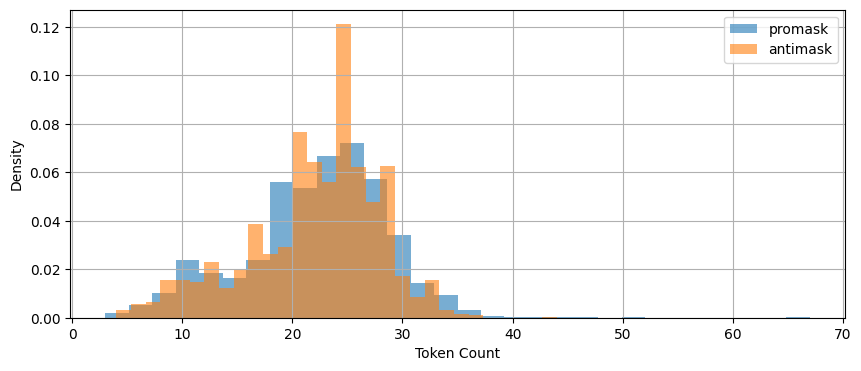

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
group,,,,,,,,,,,,
antimask,2069.0,21.899952,5.977403,4.0,6.0,10.0,19.0,23.0,26.0,30.0,33.0,44.0
promask,5000.0,22.209600,6.435336,3.0,7.0,10.0,18.0,23.0,27.0,31.0,35.0,67.0


In [ ]:
#| eval: false

fig, ax = plt.subplots(figsize=(10, 4))

for grp in ['promask', 'antimask']:
    df[df.group == grp]['token_count'].hist(
        bins=30,
        density=True,
        alpha=0.6,
        label=grp,
        ax=ax
    )

ax.legend()
ax.set_xlabel('Token Count')
ax.set_ylabel('Density')

plt.show()

df.groupby('group')['token_count'].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
)


These are very similar. 

Both groups:
- exhibit right-skewed token count distributions
- have similar central tendencies

This is useful because observations will be unlikely due to document length.

It probably won't be practical to visualize all the words in our corpus, so let's start by showing the top 30 after filtering out stopwords, punctuation, numbers, and spaces.




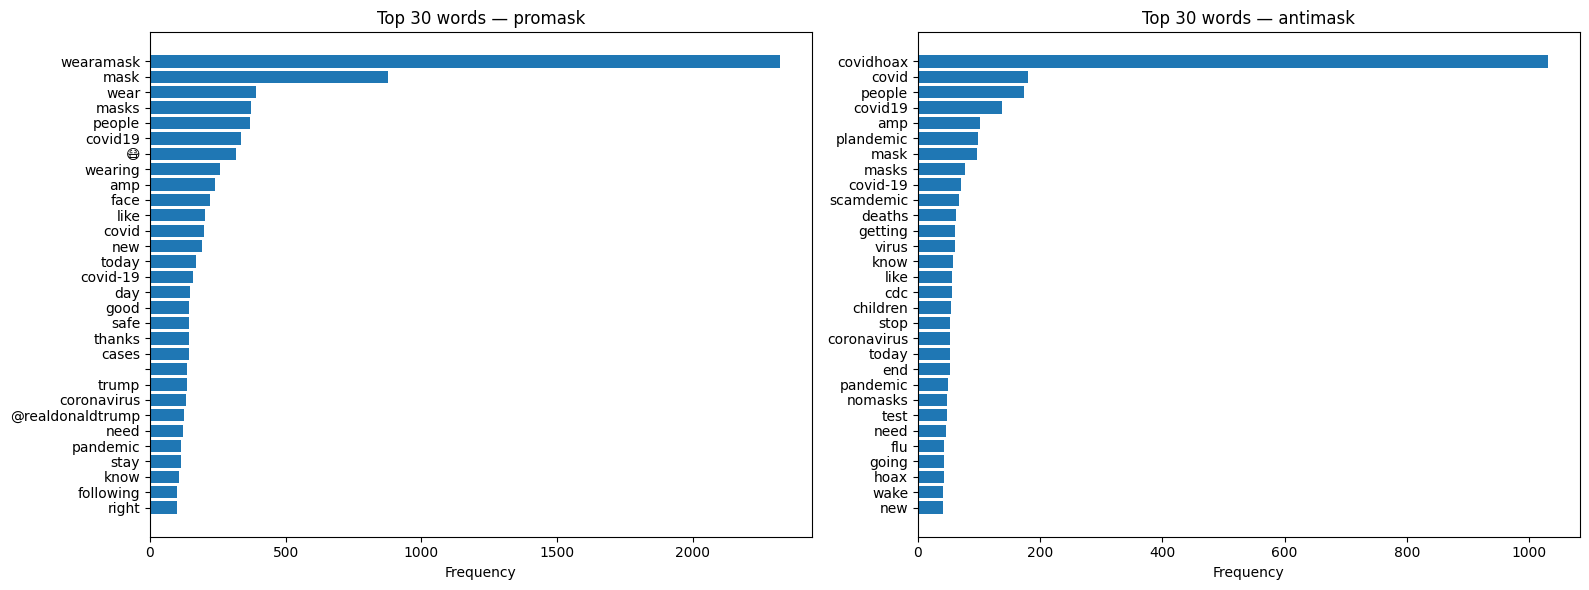

In [ ]:
#| eval: false

num_to_plot = 30
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, group in zip(axes, ['promask', 'antimask']):
    texts = df[df['group'] == group]['clean_text']
    word_counts = Counter()

    # batch processing with spaCy. nlp.pipe() is 10-50x faster
    # on real corpora. EDA on text is often bottlenecked by NLP
    # pipelines not analysis in pandas
    for doc in nlp.pipe(texts, batch_size=1000):
        for token in doc:
            if (
                not token.is_stop
                and not token.is_punct
                and not token.like_num
                and not token.is_space
            ):
                word_counts[token.text] += 1

    top_words = word_counts.most_common(num_to_plot)
    words, counts = zip(*top_words)

    ax.barh(words[::-1], counts[::-1])
    ax.set_xlabel('Frequency')
    ax.set_title(f'Top {num_to_plot} words — {group}')

plt.tight_layout()
plt.show()


Another kind of "word" you could look at are emojis. I've stubbed in an example below... what else could you examine?

In [ ]:
import regex as re

EMOJI_PATTERN = re.compile(r"\p{Emoji}")

def get_emoji(text):
    return EMOJI_PATTERN.findall(text)


In [ ]:
def extract_emojis(text):
    if not isinstance(text, str):
        return []
    return get_emoji(text)

df["emojis"] = df["tweet_text"].apply(extract_emojis)
df["emoji_count"] = df["emojis"].apply(len)

df[["tweet_text", "emojis", "emoji_count"]].tail()


,tweet_text,emojis,emoji_count
7064,@bombmunchkin Stop giving away MY Dating secre...,"[#, #, 6, 9, 9]",5
7065,Advertisers only advertise when they want mark...,"[1, 6]",2
7066,@robowen18 @annieow81 @4dannyboy @mattletiss7 ...,"[1, 8, 8, 1, 4, 7, 6]",7
7067,Another amusing musical video from Media Bear ...,"[🤣, 👍, 😂, 8, 2]",5
7068,#Republicans say the #RadicalLeft #LiberalismI...,"[#, #, #, #, 2, 4]",6


In [ ]:
df.groupby("group")["emoji_count"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
antimask,2069.0,4.383277,3.419923,0.0,2.0,4.0,6.0,28.0
promask,5000.0,4.758000,3.846816,0.0,2.0,4.0,6.0,39.0


In [ ]:
from collections import Counter

emoji_counts = (
    df
    .explode("emojis")
    .dropna(subset=["emojis"])
    .groupby("group")["emojis"]
    .apply(lambda x: Counter(x).most_common(20))
)

emoji_counts


group
antimask    [(#, 2989), (1, 904), (0, 766), (9, 761), (2, ...
promask     [(#, 7832), (1, 2160), (0, 2079), (9, 1728), (...
Name: emojis, dtype: object

Note the empty square boxes. When we decided to look at emojis as Unicode, we picked up standalone characters that are designed to combine with a base emoji. Skin-tone modifiers combine with other characters, though when by themselves - are rendered as placeholders. They were split off from their base emoji. To fix this, we would need to treat them together and use another approach to extract them.

Consider the following questions:

Which emojis appear strongly associated with one group?

Which emojis appear in both groups but with very different relative frequencies?

How do emoji patterns compare to hashtags in terms of emotional tone or stance?

We'll look at **stance** below and what it means. It's clear that emojis are rich signals that communicate affect (feelings), opinions, social cues such as solidarity, and more.

#### Keyword-in-Context

The function below is known as a **"keyword in context" (kwic)** visualization, or **concordance**. 

It works in three steps:
- Loop through texts — For each tweet, create a spaCy Doc
- Find matches — Loop through tokens, check if each matches the keyword (case-insensitive)
- Extract context — When a match is found, grab window tokens before and after

The key is getting the context window so your keyword is lined up nicely with token context:

```doc[max(0, i-window):i]``` — slice of tokens before the match (using max(0,...) to avoid negative indices)

```doc[i+1:i+1+window]``` — slice of tokens after the match

The ```:>40``` in the f-string right-aligns the left context to 40 characters, so the keyword lines up nicely in a column.

We've got a weird "amp" in our list. This looks suspiciously like poorly handled html codes. Let's explore that hypothesis with a quick concordance(key word in context or kwic) view.

In [ ]:
def kwic_spacy(texts, keyword, window=5, n=20):
    results = []

    for doc in nlp.pipe(texts, batch_size=1000):
        for i, token in enumerate(doc):
            if token.text.lower() == keyword.lower():
                left = doc[max(0, i-window):i].text.replace('\n', ' ')
                right = doc[i+1:i+1+window].text.replace('\n', ' ')
                results.append(f"{left:>40} [{token.text}] {right}")

                if len(results) >= n:
                    return results

    return results


In [ ]:
#| eval:false
nlp = get_nlp()
kwic_spacy(df['clean_text'],"amp")

✅ spaCy model 'en_core_web_sm' loaded successfully


["                ordered your semper fi & [amp] ; america's fund face",
 '                         on now. darcy & [amp] ; stacey. #darceyandstacey',
 '                     does not fit well & [amp] ; too much… https://t.co/oumpor5r0k',
 '              #staysafe #speakyourmind & [amp] ; #wearamask 😷 https://t.co/ml01hrikiz',
 '          : 25,378,371 confirmed cases & [amp] ; 850,163 deaths 90 countries',
 '                          if @ladygaga & [amp] ; her team can completely',
 '                     tweeps. take care & [amp] ; stay safe! #',
 '           good to see @usembassynepal & [amp] ; @usambnepal promoting #wearamask',
 '      @usambnepal promoting #wearamask & [amp] ; #maskchallenge even when',
 '          greg armstrong, epidemiology & [amp] ; cancer control.  ',
 '                         ariana grande & [amp] ; lady gaga  💜',
 '                   all over the states & [amp] ; continuing to spread…',
 '                      if @arianagrande & [amp] ; @ladygaga can do a',


To fix the "amp" issue (and other html artifacts), add this right after we created clean_text.

```
import html

df['clean_text'] = df['clean_text'].apply(html.unescape)
```

While kwic is very useful for analysis -- it's also handy for EDA!

## B - Distributional Patterns

Frequency alone is inadequate for revealing patterns of use. Let's look for high-frequency, low-dispersion terms. **Dispersion** measures how evenly or unevenly a word (or linguistic structure) is spread across different parts of a text corpus or dataset. Dispersion complements frequency by showing where observations occur rather than how often.

For example, a small number of users in our Twitter data could be responsible for boosting the frequency of specific terms. These could matter since they might reveal:
- Bot activity
- Coordinated messaging campaigns
- Copy-paste patterns
- Influential user amplification

**Distributional analysis** in NLP is a method that finds word meanings by analyzing their surrounding contexts. It gets at "patterns of use" rather than isolated metrics. We'll dig in much deeply into distributional analysis because it is one of the most important concepts in both NLP and LLMs.

Let's look at hashtags. We can plot in a variety of ways, though for our purposes it would be fun to compare between groups.

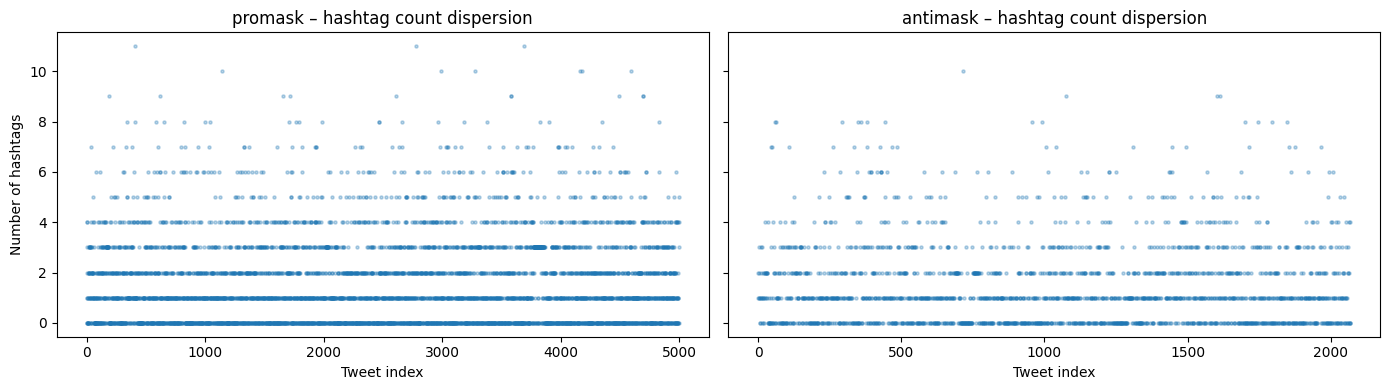

In [ ]:
#| eval: false

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group].reset_index()

    ax.scatter(
        subset.index,
        subset['num_hashtags'],
        alpha=0.3,
        s=5
    )

    ax.set_xlabel('Tweet index')
    ax.set_title(f'{group} – hashtag count dispersion')

axes[0].set_ylabel('Number of hashtags')

plt.tight_layout()
plt.show()


This plot is about **dispersion**. It shows a dense cluster of 0-4 hashtags but with some sparse outliers in each group. 

It looks like it's common to have up to about 4 hashtags. What do samples containing 8 more more look like?

In [ ]:
# Let's expand our display so we can see the entire tweet text
pd.set_option('display.max_colwidth', None)

In [ ]:
#| eval: false

# Inspect the extreme tail of the hashtag distribution (unusually hashtag-dense tweets)
df[df["num_hashtags"] >= 8][
    ["tweet_text", "num_hashtags", "group"]
].head(10)


,tweet_text,num_hashtags,group
193,#startup #healthcare #stayhome #staysafe #hopeforthebest #wearamask #washyourhands #protectyourself #protectothers… https://t.co/DGOFzacYD4,9,promask
342,#sundayinspiration got mask? \n.\n.\n.\n#gotmask #covid19nyc #covidharlem #pandemic #itsnotover #staysafer #wearamask… https://t.co/Wr24AO2sqq,8,promask
405,#Calling all #CoastlineCollege #students! Want a chance to #WIN #free #staycation #swag? Send us a #selfie wearing… https://t.co/bwDWdu2Eiq,8,promask
408,#quote #quoteoftheday #quotetoliveby #monday #inaworld #world #beanything #anything #bekind #kind #kindness… https://t.co/FRokelPXFL,11,promask
588,Mask up Washington 😷 \n.\n.\n.\n#maskup #maskupwashington #wearamask #wearyourmask #mask #selfie #maskselfie #hike… https://t.co/kv5QVJX4cp,8,promask
619,#sevenmile #sunday #wearamask l went with the #murdershewrote #jessicafletcher #angelalansbury #mask #NRC #NIKE… https://t.co/WMPfYNtBrG,9,promask
655,welcome to the Party #Nov3 #WearAMask #JoeBiden #VoteBlue #resist #CoronaVirus #NotMyPresident #VoteByMail… https://t.co/vuyCboZ1jV,8,promask
825,This is terrifying. #WearAMask #TakeCare #ByKind #Beach #BeachLife #Sunday #SundayFunDay #BeachMask https://t.co/4Vw3GnRzoz,8,promask
1004,#BidenHarris #BidenHarris2020 #NastyWoman #RidinWithBiden #NastyWomanForBiden #Masks #WearAMask #StopTheSpread… https://t.co/wemxjE0LQY,8,promask
1040,#sneezing with your #mask on feels like shitting your pants with your face! #funny #COVID19 #WearAMask #maskdebate #coronavirus #rona,8,promask


These still link to X (Twitter). Can you look at some and guess which are real people and which aren't?

Let's play around with dispersions on other sorts of words!

In [ ]:
# list some of the words we want to examine

pandemic_words =   ["pandemic", "CDC", "cure", "science", "vaccine", "virus", "guidelines", "mask", "masks", "FDA"]
conspiracy_words = ["plandemic", "scamdemic", "hoax"]
search_words = pandemic_words
moral_words = ["like", "love", "adore", "dislike", "hate", "abhor", "detest", "sickening"]
some_stopwords = ["for","a", "the", "and"]

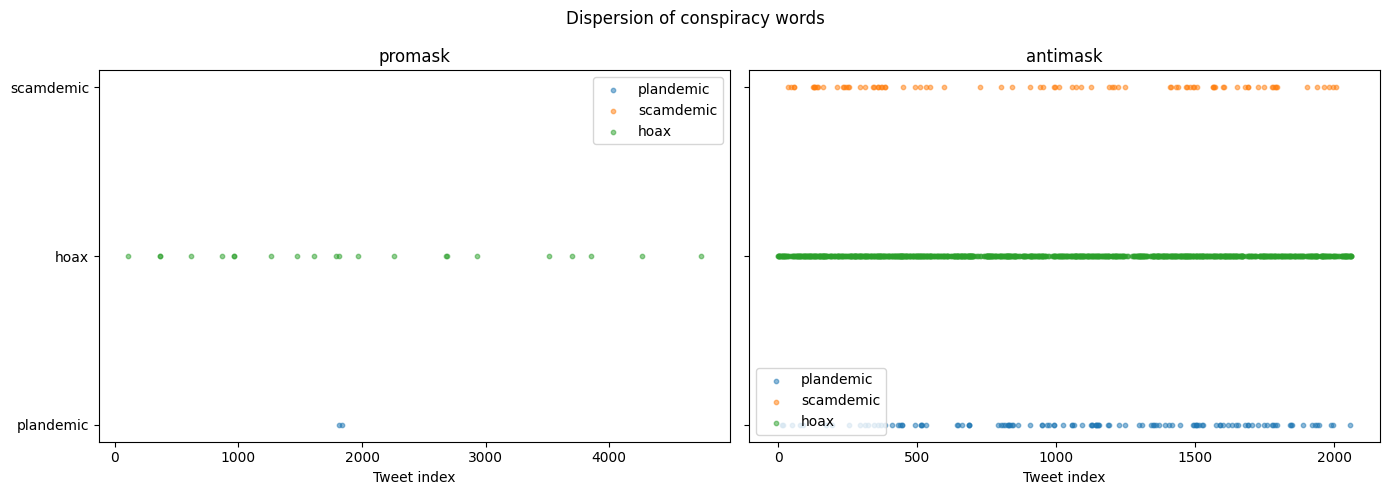

In [ ]:
#| eval: false

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group]['clean_text'].reset_index(drop=True)

    for word in conspiracy_words:
        positions = [
            i for i, text in enumerate(subset)
            if word.lower() in text.lower()
        ]
        ax.scatter(
            positions,
            [word] * len(positions),
            alpha=0.5,
            s=10,
            label=word
        )

    ax.set_xlabel('Tweet index')
    ax.set_title(group)
    ax.legend()

plt.suptitle('Dispersion of conspiracy words')
plt.tight_layout()
plt.show()


This plot is very cool! It shows where words occur... not how often. Try some yourself!

## Bonus - Word Association Patterns

Before we move on to playing with other spaCy pipeline capabilities on this data, let's look at the utility of word associations to reveal patterns in data. These techniques are used in corpus statistics used to reveal patterns in language. Very similar statistical methods are used to build word embeddings, which we'll explore soon. Embeddings are a key tool for LLMs. 

What I hope you draw from this is that we have more tools at our disposal for looking at patterns in language data when it comes to squishy questions around the **social use** of language such as attitude, opinion, ideology, power, etc. If statistics excites you, this is an interesting area of study in linguistics.



At the heart of of corpus linguistics is quantitative methodology around the co-occurence and frequencies of words and word patterns. A basic tool for looking at co-occurence patterns is via bigrams. We can look at the liklihood of association of tokens or words. To do this, we'll need to dip into statistical tests to see if associations are more more than we'd expect by chance.


### Keywords

If you think about it, keywords are a way of finding words that are more frequent in one corpus than another. What distinguishes one text from another?

A keyword list is calculated by comparing 2 frequency lists together – usually a much larger **reference corpus** against a smaller specialised corpus (but sometimes 2 equal sized corpora). We're looking for words that are more frequent in one list when compared to the other. Given we don't have a reference corpus in this lab, we'll compare our two small datasets. 

We use inferential statistics such as chi-square or log-likelihood test identify the words that are statistically much more frequent in one list when compared to the other. 

We also have to decide when is a word should be considered a keyword. To do this, we apply cut-off points for statistical
significance. Or you could set an arbitrary cutoff such as look at the top 10 or 20 words (tokens) instead.

Additionally, sometimes a minimum frequency is applied (e.g. a word must occur 20 times before it’s a keyword). Just because a word is rare is not necessarily a keyword. We'll look at an example below.

Also, we may specify a keyword has to be reasonably well-distributed (occurring in at least 20 texts, for example).

Common types of keywords:

1. Proper nouns (Clegg, Ghana etc)
2. Markers of style (often grammatical words like must, betwixt)
3. Spelling idiosyncrasies (color/colour)
4. “Aboutness” words (politics, recipe etc) 

What’s the point of this...

Keywords identify **salient** words in a corpus, acting as **signposts** for a linguistic, cultural or discursive analysis Exploring why they’re there and what they do can lead to interesting questions. 

Humans have cognitive biases when it comes to noticing frequencies. Thus, se use statistical methods that are reproducible, and have high reliability/validity from a scientific perspective. 

We're going to use **log-liklihood** for comparing frequencies across corpora. This is an important method for comparing **observed vs. expected frequencies**.

Here's the approach:

1. Count word frequencies in each corpus
2. Calculate expected frequencies based on corpus sizes
3. Compute log-likelihood (G²) for each word
4. Rank by G² to find words significantly more frequent in one corpus

First... let's bound the number of documents to see if this is useful. Using the full corpus really slows things down.

In [ ]:
#| eval: false

# sample rows *with* group so alignment is preserved
MAX_DOCS = 1000
df_s = (
    df[["clean_text", "group", "token_count"]]
    .dropna(subset=["clean_text", "group"])
    .sample(n=min(MAX_DOCS, len(df)), random_state=42)
    .reset_index(drop=True)
)

nlp = get_nlp()
docs_s = list(nlp.pipe(df_s["clean_text"], batch_size=1000))

docs_promask = [d for d, g in zip(docs_s, df_s["group"]) if g == "promask"]
docs_antimask = [d for d, g in zip(docs_s, df_s["group"]) if g == "antimask"]



✅ spaCy model 'en_core_web_sm' loaded successfully


In [ ]:
#| eval: false

# Get word frequencies

# I played around with removing things we're less interested in for this analysis such as punctuation and spaces. Freel free to do so, as well! When you filter out text like this, you must report that you did so. There will be an effect on your statistics.

# Can you think of reasons to include these sorts of things? One excellent things about spaCy is that it keeps track of spaces. We'll look at an NLP use case where this can matter.

def get_word_freqs(texts):
    freqs = Counter()
    for text in texts:
        doc = nlp(text)
        for tok in doc:
            if not tok.is_punct and not tok.is_space:
                freqs[tok.text.lower()] += 1
    return freqs
nlp = get_nlp()
promask_freqs = get_word_freqs(df[df['group']=='promask']['clean_text'])
antimask_freqs = get_word_freqs(df[df['group']=='antimask']['clean_text'])

✅ spaCy model 'en_core_web_sm' loaded successfully


In [ ]:
#| eval: false
# Let's compare by frequency by normalizing per 1000 tokens

# Get totals first
total_promask = sum(promask_freqs.values())
total_antimask = sum(antimask_freqs.values())

norm_promask = {w: (f / total_promask) * 1000 for w, f in promask_freqs.items()}
norm_antimask = {w: (f / total_antimask) * 1000 for w, f in antimask_freqs.items()}
norm_promask, norm_antimask

({'2020sucks': 0.011560827292801074,
  'trumpisscar': 0.011560827292801074,
  'ihateithere': 0.011560827292801074,
  'wearamask': 26.85580180117689,
  'black': 0.4624330917120429,
  'in': 11.08683337379623,
  'america': 0.6242846738112579,
  'https://t.co/0xjhtodsho': 0.011560827292801074,
  'this': 8.057896623082348,
  'is': 10.867177655233009,
  'probably': 0.19653406397761825,
  'one': 2.1849963583394025,
  'of': 11.768922184071492,
  'the': 24.65924461554469,
  'most': 0.5317980554688494,
  'ridiculous': 0.05780413646400536,
  'all': 4.635891744413231,
  'antimasker': 0.03468248187840322,
  'antimasking': 0.02312165458560215,
  'excuses': 0.011560827292801074,
  'ever': 0.3352639914912311,
  'recorded': 0.08092579104960751,
  'doj': 0.03468248187840322,
  'pandemic': 1.3294951386721234,
  'https://t.co/lq53brjvfi': 0.011560827292801074,
  'just': 2.982693441542677,
  'like': 2.3237262858530157,
  'do': 5.3295413819812945,
  'it': 8.809350397114418,
  'maskuphoosiers': 0.01156082729

The log-likelihood formula uses a 2x2 contingency table for each word:

|                  | Corpus 1 | Corpus 2 | Total        |
|------------------|----------|----------|--------------|
| Word X present   | a        | b        | a + b        |
| Word X absent    | c − a    | d − b    | c + d − a − b|
| **Column totals**| **c**    | **d**    | **c + d**    |



The G² statistic is:

$$G^2 = 2 \left(
a \ln\frac{a(c+d)}{c(a+b)} \;+\;
b \ln\frac{b(c+d)}{d(a+b)}
\right)$$


G² = 2 * Σ(O * ln(O/E))
where O = observed, E = expected based on overall proportions.

The idea is that for any observation (word), we want to know whether it's more frequent than we'd expect by chance. 

Some things to look at:

- We need to work with normalized frequencies.
- If we were using this for more than this sample EDA, we'd be reporting efffect size.
- Low, and rare counts are potentially an issue.
- Dispersion measures are also important. We could look at the number of tweets in which a word appears. 



In [ ]:
#| eval: false

def log_likelihood(a, b, c, d):
    """Calculate G² for a 2x2 contingency table."""
    n = a + b + c + d
    e1 = (a + b) * (a + c) / n
    e2 = (a + b) * (b + d) / n
    
    def safe_log(o, e):
        return o * math.log(o / e) if o > 0 else 0
    
    return 2 * (safe_log(a, e1) + safe_log(b, e2) + 
                safe_log(c, (a+c)*(c+d)/n) + safe_log(d, (b+d)*(c+d)/n))

# Get all words
all_words = set(promask_freqs.keys()) | set(antimask_freqs.keys())

# Calculate G² for each word
results = []
for word in all_words:
    a = promask_freqs.get(word, 0)
    b = antimask_freqs.get(word, 0)
    c = total_promask - a
    d = total_antimask - b
    g2 = log_likelihood(a, b, c, d)
    # Positive = more in promask, negative = more in antimask
    direction = 'promask' if a/total_promask > b/total_antimask else 'antimask'
    results.append((word, g2, direction, a, b))

# Sort by G² and show top keywords for each group
results.sort(key=lambda x: x[1], reverse=True)

In [ ]:
#| eval: false

results

[('covidhoax', 2551.992076720151, 'antimask', 1, 1032),
 ('wearamask', 1558.9364454759545, 'promask', 2323, 5),
 ('plandemic', 226.131446301771, 'antimask', 2, 99),
 ('😷', 218.64480244884155, 'promask', 317, 0),
 ('mask', 213.12380462102044, 'promask', 877, 97),
 ('the', 188.55280753118302, 'antimask', 2133, 1408),
 ('scamdemic', 165.3628409836379, 'antimask', 0, 67),
 ('wear', 127.31549093924573, 'promask', 391, 30),
 ('nomasks', 100.64590639777374, 'antimask', 2, 47),
 ('is', 97.02974293350962, 'antimask', 940, 644),
 ('notomasks', 91.29762506443217, 'antimask', 0, 37),
 ('hugging', 78.95691632260124, 'antimask', 0, 32),
 ('83', 74.02091221347692, 'antimask', 0, 30),
 ('safe', 72.95179442733283, 'promask', 145, 4),
 ('cdc', 70.655599284791, 'antimask', 17, 56),
 ('children', 66.79565963313857, 'antimask', 17, 54),
 ('@skynews', 66.61720535739643, 'antimask', 0, 27),
 ('💥', 66.61720535739643, 'antimask', 0, 27),
 ('face', 66.33568136788169, 'promask', 221, 19),
 ('they', 65.1267080885

No huge surprises towards the top of this list, but it's nice to see that we have a few words that are more frequent in one corpus than the other. 

#covidhoax (G²=2562) — massively more frequent in antimask tweets
#wearamask (G²=1569) — massively more frequent in promask tweets

Browse through a few more to see if you are surprised by what surfaces!

### Collocations

With keywords, we were comparing a term against other terms  in use. Let's shift to looking at the co-occurence of words. The simplest way to do this is to look at bigrams. 

Bigrams in our context are pairs of words or tokens. Here's an example below. We'll need to use bigrams and unigrams (single word/token frequencies) for some of the statistics below.

In [ ]:
nlp = get_nlp()
doc = nlp("I love wearing masks")
bigrams = [(doc[i].text, doc[i+1].text) for i in range(len(doc)-1)]
print(bigrams)

✅ spaCy model 'en_core_web_sm' loaded successfully
[('I', 'love'), ('love', 'wearing'), ('wearing', 'masks')]


**Collocations** are sequences of words that co-occur unusually frequently and that over time start to take on a meaning or a salience that resists the token sequence being broken down into its individual parts. 

Often words that start off as collocations become increasingly fixed as lexical items, especially when they are used with great frequency. This process is called **lexicalization**. 

For example, as noun-noun collocations such as 'ice chest', 'data base' or 'war game' become increasingly cemented in the vocabulary of English, even native speakers pause to wonder 'Does ice-chest have a hyphen? Is database all one word? **That is a sign of the increasing lexicalization of the collocation.**

In some cases, you can introspect about whether a collocation has a non-compositional meaning by trying to substitute it with a single synonym, such as 'cooler' for 'icechest' or 'assassin' for 'hit man' (or is that hitman?) Collocations can consist of numerous combinations of parts-of-speech, but most have in common the somewhat idiosyncratic nature of their meaning, which can exhibit differing degrees of compositionality. 

This is a challenge for second language learners, and websites such as 7esl devote some effort to helping people master them. For the purposes of natural language processing, when setting out to answer an analytic question with natural language data, it is important to consider whether and to what degree identifying collocations is relevant and necessary. How you treat collocations can affect everything from first order frequency counts to the quality of word embeddings, which are so widely used in contemporary machine learning.

**n-grams** (also written **ngrams**), are collcations. We'll talk about this term many times throughout the course, because n-grams are so central to language modeling in NLP. The n in n-gram is meant to represent a variable of any length. The gram in n-gram is a graphical representation of some chunk of language, which might be characters, morphemes, tokens, or words. Some of the shorter n-grams have special names, such as bigram or trigram, which are 2-grams and 3-grams, respectively.

Collocation measures of words are a kind of **association measure** that calculates the strength of association between words. There are many different association measures, but they all work on the same basic principle: they compare the observed frequency of a pair of words with the expected.


Useful to data scientists are the collocation graphs. Collocation graphs visually map which words commonly appear together in language. By treating words as nodes and their relationships as edges, they help us see patterns of meaning, usage, and discourse structure.

![](images/collocation-graph.png)


For collocation analysis (word associations within a corpus), these are fairly typical statistics that we can use. I won't go into how these are calculated, since this is just a demonstration. 

Here are a few commonly used statistics. We'll look at PMI and t-score, in particular. We'll first need to calculate unigram frequencies and bigram frequencies.

**PMI (Pointwise Mutual Information)** — how much more likely words co-occur than by chance (strength of association)

**t-score** — favors frequent combinations over rare (statistical confidence that co-occurence is not due to chance)

**Log-Dice** — normalized, easier to interpret across corpora

**Log-likelihood** tells you if a difference is significant; effect size measures tell you how big the difference is. Often you want both.

In [ ]:
#| eval: false

def extract_filtered_tokens(docs):
    return [
        tok.text.lower()
        for doc in docs
        for tok in doc
        if tok.is_alpha and not tok.is_stop
    ]

tokens_promask = extract_filtered_tokens(docs_promask)
tokens_antimask = extract_filtered_tokens(docs_antimask)


In [ ]:
#| eval: false

from collections import Counter

def count_bigrams(tokens):
    """
    Count bigrams from a pre-filtered token sequence.
    Assumes tokens are already lowercased, alphabetic,
    and stopwords have been removed.
    """
    return Counter(zip(tokens, tokens[1:]))


In [ ]:
#| eval: false

bigrams_promask = count_bigrams(tokens_promask)
bigrams_antimask = count_bigrams(tokens_antimask)

In [ ]:
#| eval: false

print("Top 10 bigrams — promask")
for (w1, w2), c in bigrams_promask.most_common(10):
    print(f"{w1} {w2}: {c}")

print("\nTop 10 bigrams — antimask")
for (w1, w2), c in bigrams_antimask.most_common(10):
    print(f"{w1} {w2}: {c}")


Top 10 bigrams — promask
wear mask: 35
wearing mask: 22
face mask: 14
writingcommunity stayathomesavelives: 13
stayathomesavelives wearamask: 13
mask wearamask: 13
wearing masks: 10
wearamask wearadamnmask: 9
thanks following: 8
wearamask wearamask: 8

Top 10 bigrams — antimask
covidhoax plandemic: 10
plandemic covidhoax: 7
covid covidhoax: 6
covidhoax covidhoax: 6
covidhoax forced: 5
forced quarantine: 5
quarantine camps: 5
camps operating: 5
operating bc: 5
bc canada: 5


In [ ]:
#| eval: false

from collections import Counter

def count_unigrams(tokens):
    """
    Count unigrams from a pre-filtered token sequence.
    Must match the token criteria used for bigrams.
    """
    return Counter(tokens)

# Unigrams derived from the SAME tokens as bigrams
unigrams_promask = count_unigrams(tokens_promask)
unigrams_antimask = count_unigrams(tokens_antimask)

# We can test this!
set(bigrams_promask).issubset(
    {(w1, w2) for w1 in unigrams_promask for w2 in unigrams_promask}
)


True

In [ ]:
#| eval: false

import math

def calculate_pmi(bigram_counts, unigram_counts, min_freq=5):
    """
    Calculate PMI for bigrams given aligned unigram counts.
    Assumes both were derived from the same token stream.
    """
    N = sum(bigram_counts.values())
    results = []

    for (w1, w2), count in bigram_counts.items():
        if count >= min_freq and w1 in unigram_counts and w2 in unigram_counts:
            pmi = math.log2(
                (count * N) / (unigram_counts[w1] * unigram_counts[w2])
            )
            results.append(((w1, w2), pmi, count))

    return sorted(results, key=lambda x: x[1], reverse=True)

# Calculate PMI using the already-aligned counts
pmi_promask = calculate_pmi(
    bigrams_promask,
    unigrams_promask,
    min_freq=5
)

pmi_promask[:20]


[(('wakeup', 'lied'), 9.836839359748716, 5),
 (('trying', 'understand'), 9.421801860469873, 6),
 (('understand', 'graph'), 9.421801860469873, 6),
 (('social', 'distancing'), 9.09987376558251, 5),
 (('writingcommunity', 'stayathomesavelives'), 8.72136214232878, 13),
 (('follow', 'writingcommunity'), 8.043290237216143, 5),
 (('following', 'writingcommunity'), 7.84689302441264, 6),
 (('stay', 'safe'), 7.633899301078441, 8),
 (('thanks', 'following'), 7.438808285775562, 8),
 (('thanks', 'follow'), 7.220167999300222, 5),
 (('wearing', 'masks'), 4.894324854409477, 10),
 (('wear', 'mask'), 4.70265754339091, 35),
 (('face', 'masks'), 4.608020669252835, 6),
 (('wearing', 'mask'), 4.557897189826999, 22),
 (('face', 'mask'), 4.3564819022568715, 14),
 (('stayathomesavelives', 'wearamask'), 4.046762429122948, 13),
 (('people', 'wearing'), 3.926746332101854, 5),
 (('wear', 'masks'), 3.6322682154995127, 6),
 (('wearamask', 'wearadamnmask'), 3.516247712424168, 9),
 (('people', 'wear'), 3.4016552873580

PMI suffers from a weakness. It's hard to see here, but something to know when you select an analytic. PMI is unstable for rare events. We can improve this by setting a min frequency for word occurence. Let's see what happens, if we do this.

In [ ]:
#| eval: false

pmi_promask = calculate_pmi(
    bigrams_promask,
    unigrams_promask,
    min_freq=8
)

pmi_promask[:20]

[(('writingcommunity', 'stayathomesavelives'), 8.72136214232878, 13),
 (('stay', 'safe'), 7.633899301078441, 8),
 (('thanks', 'following'), 7.438808285775562, 8),
 (('wearing', 'masks'), 4.894324854409477, 10),
 (('wear', 'mask'), 4.70265754339091, 35),
 (('wearing', 'mask'), 4.557897189826999, 22),
 (('face', 'mask'), 4.3564819022568715, 14),
 (('stayathomesavelives', 'wearamask'), 4.046762429122948, 13),
 (('wearamask', 'wearadamnmask'), 3.516247712424168, 9),
 (('mask', 'wearamask'), 0.7814178626019529, 13),
 (('wearamask', 'wearamask'), -1.328277002223977, 8)]

You can play with min_freq to see how it changes as you increase and decrease it. Because we're working with a small sample of texts, we don't see quite as much as we might on the full corpus.

There is another statistic we can use that does not share the rare events issue as PMI. Let's take a look at t-score which favors more frequent combinations.

In [ ]:
#| eval: false

import math

def calculate_tscore(bigram_counts, unigram_counts, min_freq=5):
    """
    Calculate t-score for bigrams given aligned unigram counts.
    Favors frequent, stable collocations.
    """
    N = sum(bigram_counts.values())
    results = []

    for (w1, w2), observed in bigram_counts.items():
        if observed >= min_freq and w1 in unigram_counts and w2 in unigram_counts:
            expected = (unigram_counts[w1] * unigram_counts[w2]) / N
            tscore = (observed - expected) / math.sqrt(observed)
            results.append(((w1, w2), tscore, observed))

    return sorted(results, key=lambda x: x[1], reverse=True)


# compute t-score using the same aligned counts
tscore_promask = calculate_tscore(
    bigrams_promask,
    unigrams_promask,
    min_freq=5
)

tscore_promask[:20]


[(('wear', 'mask'), 5.688887779140337, 35),
 (('wearing', 'mask'), 4.491280773251076, 22),
 (('writingcommunity', 'stayathomesavelives'), 3.597008872223415, 13),
 (('face', 'mask'), 3.5590020820224213, 14),
 (('stayathomesavelives', 'wearamask'), 3.3873914388585504, 13),
 (('wearing', 'masks'), 3.0559462899658882, 10),
 (('stay', 'safe'), 2.8141870483253566, 8),
 (('thanks', 'following'), 2.8121251368074076, 8),
 (('wearamask', 'wearadamnmask'), 2.7378045076240816, 9),
 (('trying', 'understand'), 2.4459184072733797, 6),
 (('understand', 'graph'), 2.4459184072733797, 6),
 (('following', 'writingcommunity'), 2.438850139076903, 6),
 (('face', 'masks'), 2.3490459315700902, 6),
 (('wear', 'masks'), 2.251950247397438, 6),
 (('wakeup', 'lied'), 2.2336228512258693, 5),
 (('social', 'distancing'), 2.2319927670432564, 5),
 (('follow', 'writingcommunity'), 2.2275915397502004, 5),
 (('thanks', 'follow'), 2.221071203019747, 5),
 (('staysafe', 'wearamask'), 2.153068895469887, 6),
 (('people', 'weari

If we look at both PMI and t-score, we have a useful set of tools! In summary:
- PMI highlights surprising associations (unstable for rare events)
- t-score highlights reliable, frequent collocations

You can use both because they are:
- derived from the same tokens
- computationally reasonable
- and, statistically defensible

Lest you think we must rely on sophisticated NLP *tools* using for studying study language use - here are a couple of examples using sophisticated *statistical methods* to study language use.

1. Islentyeva (2023) — [British Media Representations of EU Migrants](https://www.lancaster.ac.uk/fass/journals/cadaad/wp-content/uploads/2023/06/Islentyeva.pdf?utm_source=chatgpt.com)

A corpus-assisted analysis of two specialised corpora (500 articles each) across mainstream British newspapers before and after the Brexit referendum.

It traces linguistic patterns and ideological bias in how European migrants were discussed, noting differences between left- and right-leaning outlet

2. Gabrielatos & Baker et al. (2006/2007) — [Tabloids vs. Broadsheets on Immigration](https://www.researchgate.net/publication/261708737_Representation_of_refugees_and_asylum_seekers_in_UK_newspapers_Towards_a_corpus-based_comparison_of_the_stance_of_tabloids_and_broadsheets)

Work presented at CADAAD 2006 and in later publications explores how refugees, asylum seekers, and immigrants are framed in UK newspapers, with a focus on contrasting broadsheets vs. tabloids.

The project uses collocation and frequency analysis within a corpus framework to quantify differences in stance and lexical choices.


## C - Parts-of-Speech Patterns

The POS tagger was not trained on twitter data. So we will not find much value here.

POS can be useful is finding ways to look at things like:
- NOUN density. How much is information-heavy vs opinion-heavy
- ADJ frequency. Evaluative language
- PRON patterns. Personal involvement

I will try looking at noun chunks and also modal verbs. Exploring patterns via POS could give you interesting ideas when you start thinking about other corpora.

In [ ]:
#| eval: false

from collections import Counter

def get_pos_distribution(texts, nlp, allowed_pos=None):
    """
    Compute normalized POS tag distribution using batched spaCy processing.
    """
    if allowed_pos is None:
        allowed_pos = {
            "NOUN", "PROPN", "VERB", "ADJ", "ADV",
            "PRON", "DET", "ADP", "AUX"
        }

    pos_counts = Counter()

    for doc in nlp.pipe(texts, batch_size=1000):
        for tok in doc:
            if tok.pos_ in allowed_pos:
                pos_counts[tok.pos_] += 1

    total = sum(pos_counts.values())
    return {pos: count / total for pos, count in pos_counts.items()}


In [ ]:
#| eval: false

pos_dist_promask = get_pos_distribution(
    df[df['group'] == 'promask']['clean_text'], nlp
)

pos_dist_antimask = get_pos_distribution(
    df[df['group'] == 'antimask']['clean_text'], nlp
)

pos_dist_promask, pos_dist_antimask


({'NOUN': 0.31143695766415874,
  'ADP': 0.08735051718171215,
  'PROPN': 0.11481818531383381,
  'PRON': 0.10053961214575936,
  'AUX': 0.0600751099091247,
  'ADV': 0.04566836283469411,
  'DET': 0.06581730091387995,
  'ADJ': 0.07186710929388995,
  'VERB': 0.14242684474294723},
 {'NOUN': 0.2847861563568064,
  'ADP': 0.08756966468577762,
  'PRON': 0.09951658096499061,
  'AUX': 0.07383686916895034,
  'ADV': 0.05055885703728793,
  'DET': 0.07907134279644056,
  'VERB': 0.13954490870462175,
  'ADJ': 0.08430581642393079,
  'PROPN': 0.10080980386119408})

A few patterns stand out:

1. **PROPN (proper nouns)** — These are slightly more frequent in promask tweets. This likely reflects more use of named entities.

2. **DET (determiners)** and **AUX (auxiliaries)** — These are slightly more frequent in antimask tweets. We don't know why, though may correlate with more declarative constructions.

3. **ADV (adverbs)** and **ADJ (adjectives)** — Little differences across groups. This could suggest evaluative language is present in both groups. Evaluative language uses words and phrases to express judgment, opinion, or attitude (positive, negative, or neutral) about a topic, rather than just stating facts.

POS tags capture surface grammatical categories, not meaning. On short, informal texts like tweets, POS distributions are especially sensitive to:
- emoji and punctuation
- hashtags and mentions
- fragmented or non-standard syntax

The POS tagger used by spaCy is not trained on this kind of data. As a result, POS analysis is best treated as contextual, and not explanatory. 

Let's look at noun phrases, and modal verbs. Noun phrases often carry richer semantic content than individual words, but they are also more sensitive to parser errors—especially in informal text.

In [ ]:
#| eval: false

from collections import Counter

def get_noun_chunk_counts(docs, min_words=2):
    """
    Count noun phrases from pre-parsed spaCy Docs.
    Filters out single-word chunks.
    """
    chunk_counts = Counter()

    for doc in docs:
        for chunk in doc.noun_chunks:
            if len(chunk) >= min_words:
                chunk_counts[chunk.text.lower()] += 1

    return chunk_counts


chunks_promask = get_noun_chunk_counts(docs_promask)
chunks_antimask = get_noun_chunk_counts(docs_antimask)


In [ ]:
#| eval: false

chunks_promask.most_common(10), chunks_antimask.most_common(10)

([('#wearamask', 60),
  ('a mask', 51),
  ('#covid19', 19),
  ('#stayathomesavelives', 13),
  ('the spread', 7),
  ('#writingcommunity', 7),
  ('that graph', 6),
  ('your mask', 6),
  ('no one', 5),
  ('#wakeup', 5)],
 [('#covidhoax', 8),
  ('#covid19', 7),
  ('the #covidhoax', 6),
  ('bc canada', 5),
  ('the world', 5),
  ('only 6%', 4),
  ('our lawyers', 3),
  ('#kbf', 3),
  ('the lies', 3),
  ('a mask', 3)])

Doing these analyses is getting easier (and more repetitive) now that we've created functions like this.

Now let's look at the frequency of modal verbs. Modal verbs (typically auxiliary verbs) express modality—obligation, permission, or possibility—and often signal prescriptive or normative language.

We'll look at several types of modality:
- Strong obligation: must, need to
- Weaker obligation: should, ought to 
- Prohibition: can't, must not, shouldn't

We could also consider imperative verbs (e.g., "wear", "stop", "wake up") — they're prescriptive too.

In [ ]:
modals = {
    'strong': ['must', 'need', 'have'],  # "have to" needs special handling
    'medium': ['should', 'ought'],
    'weak': ['can', 'could', 'may', 'might']
}

In [ ]:
# build inverse mapping: lemma -> strength
modal_to_strength = {
    modal: strength
    for strength, modal_list in modals.items()
    for modal in modal_list
}


In [ ]:
#| eval: false

from collections import Counter

def get_modal_counts_from_docs(docs):
    """
    Count modal verbs from pre-parsed spaCy Docs.
    Restricts to AUX tokens to avoid false positives.
    """
    modal_counts = Counter()

    for doc in docs:
        for tok in doc:
            if tok.pos_ == "AUX":
                strength = modal_to_strength.get(tok.lemma_.lower())
                if strength:
                    modal_counts[strength] += 1

    return modal_counts

modals_promask = get_modal_counts_from_docs(docs_promask)
modals_antimask = get_modal_counts_from_docs(docs_antimask)

modals_promask, modals_antimask



(Counter({'weak': 83, 'strong': 51, 'medium': 12}),
 Counter({'strong': 35, 'weak': 29, 'medium': 3}))

In [ ]:
#| eval: false

len(docs_promask), len(docs_antimask)

(714, 286)

In [ ]:
#| eval: false

# Normalized modal rates per 1000 tokens (same sample as modal counts)
total_promask_tokens = df_s[df_s["group"] == "promask"]["token_count"].sum()
total_antimask_tokens = df_s[df_s["group"] == "antimask"]["token_count"].sum()

rate_strong_promask = modals_promask.get("strong", 0) / total_promask_tokens * 1000
rate_strong_antimask = modals_antimask.get("strong", 0) / total_antimask_tokens * 1000

rate_strong_promask, rate_strong_antimask


(np.float64(3.2378896577995047), np.float64(5.672609400324149))

## D - Lexical Variety Through Lemmatization

Let's lemmatize our tokens. It might be interesting to look at lemmas unique to each group and common to both groups.

You'll need to type in variable names to explore these. I've just added shared_lemmas, as an example. 

In [ ]:
#| eval: false

def get_unique_lemmas_from_docs(docs):
    """
    Extract unique content-word lemmas from pre-parsed spaCy Docs.
    """
    lemmas = set()

    for doc in docs:
        for tok in doc:
            if (
                tok.is_alpha
                and not tok.is_stop
                and tok.pos_ in {"NOUN", "VERB", "ADJ", "ADV"}
            ):
                lemmas.add(tok.lemma_.lower())

    return lemmas


In [ ]:
#| eval: false

promask_lemmas = get_unique_lemmas_from_docs(docs_promask)
antimask_lemmas = get_unique_lemmas_from_docs(docs_antimask)

unique_to_promask_lemmas = promask_lemmas - antimask_lemmas
unique_to_antimask_lemmas = antimask_lemmas - promask_lemmas
shared_lemmas = promask_lemmas & antimask_lemmas


In [ ]:
#| eval: false

shared_lemmas

{'able',
 'absolutely',
 'accept',
 'actually',
 'admit',
 'age',
 'agree',
 'airport',
 'alive',
 'allow',
 'amazing',
 'anymore',
 'area',
 'arrest',
 'article',
 'ask',
 'ass',
 'attend',
 'average',
 'bad',
 'beach',
 'beat',
 'believe',
 'bet',
 'big',
 'bloo',
 'body',
 'book',
 'boy',
 'break',
 'breaking',
 'breathe',
 'bring',
 'business',
 'busy',
 'buy',
 'c',
 'call',
 'camp',
 'care',
 'case',
 'cause',
 'change',
 'check',
 'cheer',
 'child',
 'choice',
 'citizen',
 'claim',
 'class',
 'clean',
 'clear',
 'click',
 'close',
 'come',
 'comfortable',
 'comment',
 'company',
 'completely',
 'compliance',
 'concerned',
 'continue',
 'control',
 'convince',
 'coronavirus',
 'cost',
 'country',
 'course',
 'covid',
 'covididiot',
 'crash',
 'crowd',
 'curious',
 'curve',
 'daily',
 'damn',
 'dangerous',
 'date',
 'datum',
 'day',
 'deadly',
 'deal',
 'death',
 'decide',
 'democrat',
 'design',
 'destroy',
 'dictator',
 'die',
 'difference',
 'different',
 'dirty',
 'distance',


In [ ]:
#| eval: false

df_s["group"].value_counts()


group
promask     714
antimask    286
Name: count, dtype: int64

In [ ]:
#| eval: false

df_s[df_s["group"] == "antimask"].head()


,clean_text,group,token_count
3,"@jacquie72832803 @otvdesk @mssassysally @borisjohnson the globalist bankers are in control, just like they are in m… https://t.co/6oc2tnyx6n",antimask,19
5,man that’s good to see nz rising up #covidhoax https://t.co/fcje2i3a5a,antimask,13
12,"only 9,210 deaths caused by #covid19 in the us, not the 153,504 publicized by the media. throw out your face dia… https://t.co/jkx8wbgjxp",antimask,28
13,@13abc why even bother testing? these tests are completely meaningless and the only purpose they serve is to perpe… https://t.co/xaibqhivky,antimask,23
18,@nashgette exactly! that is my point. #covidhoax,antimask,10


## E - Named Entity Recognition

As with POS tagging, we don't expect these analytics to be particularly useful. The NER component was not trained on tweet text and will do poorly. Nonetheless, let's take a quick look so you are able to see how to use it.

Entity type distributions
 
Aggregate across corpus
- PERSON mentions (authorities, politicians, scientists)
- ORG mentions (CDC, WHO, government agencies)
- GPE (locations - local vs. national vs. international framing)
- DATE (temporal framing differences)

How well might we be able to detect people mentions?

How well might we be able to find interesting patterns of co-occurence of entities?
    - Which entities appear together in tweets?
    - Example: "Fauci" + "lie" vs. "Fauci" + "expert"
    - Simple co-occurrence matrix for top 10 entities

Later, we will talk about how must evaluate the quality of NER. For now, let's just practice using it.




In [ ]:
#| eval: false

# We'll speed this up by disabling a few components since we're only looking at entity types

def get_entity_types(texts, nlp):
    ent_counts = Counter()
    for doc in nlp.pipe(
    texts,
    batch_size=1000,
    disable=["tagger", "parser", "lemmatizer"]
):
        ent_counts.update(ent.label_ for ent in doc.ents)
    return ent_counts

ents_promask = get_entity_types(
    df[df["group"] == "promask"]["tweet_text"],
    nlp
)

nlp = get_nlp()
ents_antimask = get_entity_types(
    df[df["group"] == "antimask"]["tweet_text"],
    nlp
)
ents_promask.most_common(10), ents_antimask.most_common(10)

✅ spaCy model 'en_core_web_sm' loaded successfully


([('PERSON', 2304),
  ('CARDINAL', 1891),
  ('ORG', 1698),
  ('DATE', 911),
  ('MONEY', 818),
  ('GPE', 671),
  ('NORP', 211),
  ('TIME', 142),
  ('PRODUCT', 112),
  ('ORDINAL', 92)],
 [('PERSON', 943),
  ('ORG', 858),
  ('CARDINAL', 654),
  ('PRODUCT', 528),
  ('MONEY', 296),
  ('GPE', 291),
  ('DATE', 273),
  ('NORP', 155),
  ('PERCENT', 78),
  ('ORDINAL', 35)])

We use nlp.pipe() rather than calling nlp(text) in a loop because spaCy is optimized for batch processing. On larger datasets, this can reduce runtime by an order of magnitude.

In [ ]:
def get_entities_by_type(texts, ent_type, nlp):
    ents = Counter()
    for doc in nlp.pipe(
        texts,
        batch_size=1000,
        disable=["tagger", "parser", "lemmatizer"]
    ):
        for ent in doc.ents:
            if ent.label_ == ent_type:
                ents[ent.text] += 1
    return ents


In [ ]:
#| eval: false

get_entities_by_type(
    df[df['group'] == 'promask']['tweet_text'],
    'ORG',
    nlp
).most_common(20),

get_entities_by_type(
    df[df['group'] == 'antimask']['tweet_text'],
    'ORG',
    nlp
).most_common(20)


[('CovidHoax', 87),
 ('CDC', 50),
 ('COVIDIOTS', 19),
 ('BC Canada', 16),
 ('COVIDHOAX', 15),
 ('NHS', 12),
 ('NEVER', 9),
 ('COVID-19', 8),
 ('Trump', 7),
 ('MSM', 7),
 ('BBC', 6),
 ('NFL', 6),
 ('Plandemic', 6),
 ('BS', 5),
 ('RNC', 5),
 ('CovidHoax &', 4),
 ('UN', 4),
 ('BLM', 4),
 ('NJ', 4),
 ('the W H O  wanna', 4)]

In [ ]:
def get_entity_cooccurrence(texts, ent_type, nlp, top_n=10):

    # First pass: get most frequent entities
    ent_counts = get_entities_by_type(texts, ent_type, nlp)
    top_ents = {e for e, _ in ent_counts.most_common(top_n)}

    cooc = Counter()

    # Second pass: count co-occurrence within tweets
    for doc in nlp.pipe(
        texts,
        batch_size=1000,
        disable=["tagger", "parser", "lemmatizer"]
    ):
        ents_in_doc = [
            ent.text for ent in doc.ents
            if ent.label_ == ent_type and ent.text in top_ents
        ]

        for i, e1 in enumerate(ents_in_doc):
            for e2 in ents_in_doc[i+1:]:
                cooc[tuple(sorted((e1, e2)))] += 1

    return list(top_ents), cooc


In [ ]:
#| eval: false

top_promask, cooc_promask = get_entity_cooccurrence(
    df[df['group'] == 'promask']['tweet_text'],
    ent_type='PERSON',
    nlp=nlp
)

top_antimask, cooc_antimask = get_entity_cooccurrence(
    df[df['group'] == 'antimask']['tweet_text'],
    ent_type='PERSON',
    nlp=nlp
)

top_promask, top_antimask

(['WearAMask',
  'COVIDー19',
  'COVID-19',
  'Trump',
  'Covid',
  'COVID',
  '😷',
  'SocialDistancing',
  '@WHO',
  'covid19'],
 ['COVIDー19',
  'CovidHoax',
  'scamdemic2020',
  'COVIDIOT',
  'Trump',
  'COVIDHOAX',
  'NoMasks',
  'Covid',
  'COVID',
  'KBF'])

### Interpreting these results

The analyses above focus on **surface-level linguistic features**:
- token and hashtag frequency
- part-of-speech distributions
- named entities and co-occurrence

While interesting, they aren't particularly revealing about stance, irony, causality, or implied meaning. Differences should be interpreted as *descriptive patterns*, not explanations. They aren't particularly useful for EDA on this dataset.


## F - Reflection 

1. Which surface-level linguistic features most clearly distinguish these communities (e.g., tokens, hashtags, POS distributions, named entities), and how do we know? Focus on observable patterns in the data rather than inferred motivations or beliefs.

2. What aspects of linguistic variety were detectable using word frequency, corpus statistics, and spaCy’s rule-based or statistical methods? What kinds of variation were not well captured?

3. Based on this EDA, which analytical tasks are best suited to:
- Corpus statistics (e.g., frequency, dispersion, collocations)?
- Classical NLP methods (rules, POS tagging, NER)?
- Large language models (LLMs)?

Explain why each method is appropriate for those tasks, and give at least one concrete example from this notebook.


In [ ]:
q3_answer = "What language features most strongly distinguish these communities?"

In [ ]:
q4_answer = "What aspects of variety were we able to detect with statistical methods or spaCy classical NLP methods? "

In [ ]:
q5_answer = "What tasks might benefit from corpus statistics methods vs classical NLP methds vs. LLMs?"

## G - LLM Analysis


From the last lab we learned that we could create a function like this to call an LLM:
```
chat = make_chat(model=DEFAULT_MODEL)

def llm_summarize(text):
    """
    Generate abstractive summary using available LLM.
    Returns plain text.
    """
    prompt = f"""
    Summarize this article in exactly:

    - 3 bullet points (key facts)
    - 1 headline (max 10 words)

    Article:
    {text}

    Format your response as:

    HEADLINE: <headline>

    • <bullet 1>
    • <bullet 2>
    • <bullet 3>
    """

    return chat(prompt)

summary_text = llm_summarize(article)
print(summary_text)
```

### G.1 - Hashtags

Hashtags are linguistically weird:
- No spaces: #CovidIsntReal
- Mixed case semantics: #wearAMask vs #WearAMask vs #WEARAMASK
- Compound meanings: #DoYourOwnResearch (literal + ideological signal)
- Emoji integration: #MaskUp😷 or #NoMasks🙅‍♂️
- Sarcasm markers: #TrustTheScience (could be genuine or mocking)

Could we create custom functions to break hashtags into words? With some effort and degree of error, yes. As it stands, spaCy treats hashtags as proper nouns, doesn't parse internal structure, and can't interpret emoji semantics. POS won't help us much... nor will NER or spaCy dependency parsing. Let's see what an LLM can tell us.

In [ ]:
# Example tweets illustrating how hashtags and emoji carry meaning
# that classical NLP struggles to represent

doc = nlp("#DoYourOwnResearch 🐑 #WakeUp")
for token in doc:
    print(f"{token.text:20} {token.pos_:10} {token.lemma_}")


#                    SYM        #
DoYourOwnResearch    NOUN       doyourownresearch
🐑                    NOUN       🐑
#                    SYM        #
WakeUp               PROPN      WakeUp


In [ ]:
tweets = [
    "#DoYourOwnResearch 🐑 #WakeUp Don't let them tell you what to think",
    
    "Proud to #WearAMask 😷 Protecting my community! #InThisTogether ❤️",
    
    "#TrustTheScience right into the grave 💀 #CovidHoax",
    
    "My freedoms > your fears 🇺🇸 #NoMasks #LiveFree or don't idc"
]

In [ ]:
#| eval: false

def llm_analyze_tweet(text, model=DEFAULT_MODEL):
    "Analyze tweet for hashtag semantics, ideological signals, and ambiguity"
    prompt = f"""Analyze this tweet for linguistic and social signals:

1. "#DoYourOwnResearch 🐑 #WakeUp Don't let them tell you what to think"
    
2. "Proud to #WearAMask 😷 Protecting my community! #InThisTogether ❤️"
    
3. "#TrustTheScience right into the grave 💀 #CovidHoax"
    
4. "My freedoms > your fears 🇺🇸 #NoMasks #LiveFree or don't idc"

For each hashtag, convey literal meaning, ideological signal, and whether it's sincere/ironic/ambiguous. Explain reasoning.
"""
    
    chat = make_chat(model)
    return chat(prompt)

llm_analyze_tweet(tweets)

# Analysis of Tweets

## Tweet 1: "#DoYourOwnResearch 🐑 #WakeUp Don't let them tell you what to think"

**#DoYourOwnResearch**
- *Literal*: Encouragement to independently investigate information
- *Ideological signal*: Anti-establishment, skepticism of mainstream sources/authorities
- *Tone*: **Sincere** - Core rallying cry of conspiracy-adjacent communities
- *Reasoning*: Commonly used to reject expert consensus in favor of alternative sources

**#WakeUp**
- *Literal*: Become alert or aware
- *Ideological signal*: Suggests others are "asleep" (ignorant) to hidden truths
- *Tone*: **Sincere**
- *Reasoning*: Classic conspiratorial framing implying special knowledge

**🐑 (sheep emoji)**
- *Literal*: Farm animal
- *Ideological signal*: Derogatory term for "sheeple" - conformists who blindly follow
- *Tone*: **Sincere contempt**
- *Reasoning*: Positions author as independent thinker vs. conformist masses

**Overall stance**: Anti-authority, libertarian/populist right, likely COVID-skeptic or conspiracy-oriented

---

## Tweet 2: "Proud to #WearAMask 😷 Protecting my community! #InThisTogether ❤️"

**#WearAMask**
- *Literal*: Advocacy for face covering
- *Ideological signal*: Pro-public health measures, collective responsibility
- *Tone*: **Sincere**
- *Reasoning*: Straightforward public health messaging

**#InThisTogether**
- *Literal*: Expression of solidarity
- *Ideological signal*: Communitarian values, shared sacrifice for collective good
- *Tone*: **Sincere**
- *Reasoning*: Mainstream pandemic solidarity slogan, earnest tone throughout

**😷❤️ (emojis)**
- *Signal*: Wholesome, community-minded, empathetic
- *Reasoning*: Heart emoji reinforces care ethic

**Overall stance**: Pro-social safety measures, left-leaning or centrist, values collective welfare over individual autonomy

---

## Tweet 3: "#TrustTheScience right into the grave 💀 #CovidHoax"

**#TrustTheScience**
- *Literal*: Follow scientific guidance
- *Ideological signal*: **IRONIC/SARCASTIC** mockery of pro-science messaging
- *Tone*: **Hostile irony**
- *Reasoning*: Context ("into the grave") reveals this is mockery, not endorsement

**#CovidHoax**
- *Literal*: Claim COVID-19 is fabricated/exaggerated
- *Ideological signal*: Conspiracy belief, denial of pandemic severity
- *Tone*: **Sincere**
- *Reasoning*: Direct statement of conspiratorial belief

**💀 (skull emoji)**
- *Signal*: Death/danger - used to suggest science/medicine is lethal
- *Reasoning*: Implies following health guidance causes harm

**Overall stance**: Far-right conspiracy adherent, anti-science, views medical establishment as malevolent

---

## Tweet 4: "My freedoms > your fears 🇺🇸 #NoMasks #LiveFree or don't idc"

**"My freedoms > your fears"**
- *Literal*: Individual liberty prioritized over others' concerns
- *Ideological signal*: Libertarian individualism, rejection of collective obligations
- *Tone*: **Sincere** with **performative indifference**
- *Reasoning*: Explicit value statement

**#NoMasks**
- *Literal*: Opposition to mask-wearing
- *Ideological signal*: Anti-mandate, personal sovereignty
- *Tone*: **Sincere**

**#LiveFree**
- *Literal*: "Live Free or Die" reference (New Hampshire motto)
- *Ideological signal*: American libertarian ideology
- *Tone*: **Sincere**

**"or don't idc" (I don't care)**
- *Signal*: **Ambiguous** - Could be genuine apathy OR defensive posturing
- *Reasoning*: Contradiction - someone who "doesn't care" wouldn't post; likely signals "I'm unbothered by criticism"

**🇺🇸 (flag emoji)**
- *Signal*: Patriotism framed through libertarian lens
- *Reasoning*: Freedom as ultimate American value

**Overall stance**: Right-libertarian, individualist, anti-collectivist, views public health measures as tyranny

---

## Cross-Cutting Patterns

**In-group/out-group dynamics**: All tweets signal tribal membership
- 1 & 3: "Awake" vs. "sheep"
- 2: Community-minded vs. selfish
- 4: Freedom-lovers vs. fearful

**Moral foundations**: 
- Tweets 1, 3, 4: Liberty/oppression axis dominates
- Tweet 2: Care/harm and fairness/cheating axes

**Linguistic certainty**: All express high confidence, no hedging or nuance

<details>

- id: `chatcmpl-5532acb1-f323-4b43-91da-a98f4d244219`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1267, prompt_tokens=169, total_tokens=1436, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

#### Reflection

1. Which of these signals were invisible to corpus stats and spaCy?
2. 
3. How do you think the LLM 'knows' that 🐑 is being used ironically here? Where does that knowledge come from? (Consider distributional information.)

4. The LLM recognizes '#DoYourOwnResearch' as ideologically loaded. How do you think it learn that association? Could we build that classically?



In [ ]:
q6_answer = "What information did LLMs infer that SpaCy components couldn't?"

In [ ]:
q7_answer = "How did the LLM know that 🐑 indicated irony?"

In [ ]:
q8_answer = "How did the LLM recognizes an association of #DoYourOwnResearch to ideology?"

### G.2 Stance Detection

'Stance' indicates a position on a target (e.g., a topic). 

Stance isn't always explicit. People signal positions through:
- Sarcasm and irony
- Rhetorical questions
- Presupposition and framing
- Tone and affect


Let's look at tweet pairs that look superficially similar.


In [ ]:
#| eval: false

def llm_analyze_tweet(model=DEFAULT_MODEL):
    "Analyze stance and use of language and emoji"
    prompt = f"""Analyze this tweet for linguistic and social signals:
   
Tweet 1: , "Wow, masks really work 😂"

Tweet 2: "Science says masks work. Period."

Tweet 3: "Sure, trust the 'experts' 🙄"

Tweet 4: "Trust the experts. They know what they're doing."

For each tweet, determine:
1. Explicit stance (pro-mask, anti-mask, neutral)
2. Confidence level (high/medium/low)
3. Key linguistic cues that reveal stance
4. Any irony, sarcasm, or non-literal language
5. How emoji/punctuation modifies meaning"""
    
    chat = make_chat(model)
    return chat(prompt)

llm_analyze_tweet()




# Linguistic and Social Signal Analysis

## Tweet 1: "Wow, masks really work 😂"

1. **Explicit stance:** Anti-mask
2. **Confidence level:** High
3. **Key linguistic cues:**
   - "Wow" - mock surprise/exaggerated reaction
   - "really" - intensifier used sarcastically
   - Simple declarative structure undermined by context
4. **Irony/Sarcasm:** Strong sarcasm throughout. The speaker means the opposite of what they're saying.
5. **Emoji/Punctuation effect:** 
   - 😂 (laughing emoji) is critical - transforms the statement from sincere to mocking
   - Signals ridicule and disbelief

---

## Tweet 2: "Science says masks work. Period."

1. **Explicit stance:** Pro-mask
2. **Confidence level:** High
3. **Key linguistic cues:**
   - "Science says" - appeals to authority
   - "Period" - conversation-ending declaration
   - Short, declarative sentences convey certainty
4. **Irony/Sarcasm:** None - literal, straightforward statement
5. **Punctuation effect:**
   - "Period" as separate sentence = emphatic, non-negotiable
   - Mimics spoken emphasis to shut down debate

---

## Tweet 3: "Sure, trust the 'experts' 🙄"

1. **Explicit stance:** Anti-establishment/anti-mask (implied)
2. **Confidence level:** High
3. **Key linguistic cues:**
   - "Sure" - dismissive agreement (false concession)
   - Scare quotes around 'experts' - delegitimizes authority
   - Imperative verb "trust" presented mockingly
4. **Irony/Sarcasm:** Heavy sarcasm; means opposite of surface meaning
5. **Emoji/Punctuation effect:**
   - 🙄 (eye roll) confirms sarcastic dismissal
   - Scare quotes signal the speaker questions experts' legitimacy/credentials

---

## Tweet 4: "Trust the experts. They know what they're doing."

1. **Explicit stance:** Pro-establishment/pro-mask (implied)
2. **Confidence level:** Medium-High
3. **Key linguistic cues:**
   - Imperative "Trust" - directive to audience
   - "They know what they're doing" - affirms competence
   - Straightforward syntax with no hedging
4. **Irony/Sarcasm:** None apparent - reads as sincere
5. **Punctuation effect:**
   - Two sentences create measured, reasonable tone
   - Period placement = authoritative but not aggressive

---

## Key Comparative Observations:

- **Tweets 1 & 3** use nearly identical linguistic structures to **Tweets 2 & 4** but mean the opposite due to sarcasm markers
- **Emoji and punctuation are decisive** in determining stance - without 😂 and 🙄, Tweets 1 & 3 would be ambiguous
- **Scare quotes** are a reliable indicator of dismissive stance
- **"Period"** vs **eye-roll emoji** represent opposing rhetorical strategies for expressing certainty

<details>

- id: `chatcmpl-902a13cc-dd54-4a95-9846-699e50ad1851`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=759, prompt_tokens=157, total_tokens=916, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

#### Reflection

1. The LLM 'knows' that 😂 + positive claim often = sarcasm. How did it learn this? Could we build an ML model to detect this or encode it as a rule?

2. Are these confidence levels real or simply generated patterns? How could we tell?

3. How do we know the LLM is right? For spaCy, we can check POS tags manually. For stance detection, what's our ground truth?



In [ ]:
q9_answer = "Could we use rules or ML to detect sarcasm?"

In [ ]:
q10_answer = "Are confidence levels given by an LLM real or simply generated?"

In [ ]:
q11_answer = "How could we validate whether an LLM is right?"

## Lab Reflection 

1. The LLM offers rich interpretation, but how do we validate it? What's our ground truth for 'correct' analysis of implicit meaning?

2. Scalability vs. depth trade-off:
    - spaCy: 10,000 tweets, POS tags, in 10 seconds
    - LLM: 10 tweets, deep analysis, in 30 seconds
    - "When do you need which?"

3. How might you combine both traditional NLP methods with LLMs? For example:"
    - Use spaCy to identify tweets with high emoji density → flag for LLM analysis
    - Use spaCy to extract all hashtags → use LLM to categorize their ideological valence
    - Use spaCy for entity extraction → use LLM to analyze how entities are framed

4. The LLM was trained on internet text that includes political discourse. Could it have learned political biases? How would we detect that?

5. What did you find most interesting from this lab?
  
6. What did you find most surprising from this lab?

In [ ]:
q12_answer = "How could we validate LLM interpretations?"

In [ ]:
q13_answer = "For what tasks might we prefer the scalability of spaCy vs depth of an LLM?"

In [ ]:
q14_answer = "How might we combine traditional NLP methods with LLMs?"

In [ ]:
q15_answer = "Could an LLM learn political biases and how could we tell?"

In [ ]:
q16_answer = "What did you find most interesting from this lab?"

In [ ]:
q17_answer = "What did you find most surprising from this lab?"

In [ ]:
#| eval: false

NOTEBOOK_PATH = "02-eda-spacy.ipynb"

from data401_nlp.helpers.submit import review_answers, submit_answers

review_answers(path=NOTEBOOK_PATH)


📝 REVIEW: Answers detected in this notebook
q1_answer: 'Do you think these datasets are representative of twitter conversation about Covid-19 (at that time). Why or why not?'
q2_answer: 'How might you expand coverage to address representativeness vs balance on some particular task such as public sentiment?'
q3_answer: 'What language features most strongly distinguish these communities?'
q4_answer: 'What aspects of variety were we able to detect with statistical methods or spaCy classical NLP methods? '
q5_answer: 'What tasks might benefit from corpus statistics methods vs classical NLP methds vs. LLMs?'
q6_answer: "What information did LLMs infer that SpaCy components couldn't?"
q7_answer: 'How did the LLM know that 🐑 indicated irony?'
q8_answer: 'How did the LLM recognizes an association of #DoYourOwnResearch to ideology?'
q9_answer: 'Could we use rules or ML to detect sarcasm?'
q10_answer: 'Are confidence levels given by an LLM real or simply generated?'
q11_answer: 'How could we va

{'q1_answer': 'Do you think these datasets are representative of twitter conversation about Covid-19 (at that time). Why or why not?',
 'q2_answer': 'How might you expand coverage to address representativeness vs balance on some particular task such as public sentiment?',
 'q3_answer': 'What language features most strongly distinguish these communities?',
 'q4_answer': 'What aspects of variety were we able to detect with statistical methods or spaCy classical NLP methods? ',
 'q5_answer': 'What tasks might benefit from corpus statistics methods vs classical NLP methds vs. LLMs?',
 'q6_answer': "What information did LLMs infer that SpaCy components couldn't?",
 'q7_answer': 'How did the LLM know that 🐑 indicated irony?',
 'q8_answer': 'How did the LLM recognizes an association of #DoYourOwnResearch to ideology?',
 'q9_answer': 'Could we use rules or ML to detect sarcasm?',
 'q10_answer': 'Are confidence levels given by an LLM real or simply generated?',
 'q11_answer': 'How could we vali

In [ ]:
#| eval: false

ALLOW_SUBMISSION = False  # student must change intentionally

def submit_for_credit(student_id):
    if not os.getenv("SUBMIT_API_KEY"):
        raise RuntimeError(
            "SUBMIT_API_KEY not found. Did you run the environment setup cell at the top of the notebook?"
        )
    
    if not ALLOW_SUBMISSION:
        raise RuntimeError(
            "⚠️ Submission is currently disabled.\n\n"
            "To submit:\n"
            "  1. Review your answers\n"
            "  2. Set ALLOW_SUBMISSION = True\n"
            "  3. Re-run this cell"
        )

    submit_answers(
        student_id=student_id,
        path=NOTEBOOK_PATH,
    )

# Don't forget to edit with your name
submit_for_credit("your name")

RuntimeError: ⚠️ Submission is currently disabled.

To submit:
  1. Review your answers
  2. Set ALLOW_SUBMISSION = True
  3. Re-run this cell